<a href="https://colab.research.google.com/github/KU-BIG/KUBIG_2023_SPRING/blob/main/1.%20%EB%B0%A9%ED%95%99%EB%B6%84%EB%B0%98/DL/%EA%B3%BC%EC%A0%9C/3%EC%A3%BC%EC%B0%A8/3%E1%84%8C%E1%85%AE%E1%84%8E%E1%85%A1_%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A6_%EA%B9%80%EC%97%B0%EA%B7%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3주차 과제 1 : MLP 마음대로 다뤄보기
- load_digits(), load_wine() 중 원하는 데이터셋 하나를 선택하여,  
activation function, lr, optimizer, hidden layer/neuron 수를 바꾸어 가며 모든 시도를 올리기.
- 제일 높은 acc를 보인 시도 명시하기!

### 데이터 로드하기

In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from torch.utils.data import  Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# 데이터셋 종류 : load_digits
data = load_digits()

load_digits 데이터셋은 Bunch(dictionary) 타입이므로, 각 속성을 불러와 살펴본다.

In [3]:
input = data.data
output = data.target

In [4]:
print("data: ", input)

data:  [[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


In [5]:
print("target: ", output)

target:  [0 1 2 ... 8 9 8]


In [6]:
data.data.shape # 데이터셋의 크기

(1797, 64)

.images 속성 안에 raw 이미지 데이터가 배열 형태로 저장되어 있다.

In [7]:
data.images[0].shape # 이미지 한 장의 크기

(8, 8)

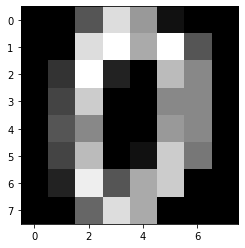

In [8]:
# 이미지 출력하기
plt.imshow(data.images[0], cmap='gray')
plt.show()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)

In [10]:
# 배치 경사 하강 알고리즘 활용
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김(.to(device))
#  그러나 뒤에서 평가 및 그래프 출력 시 텐서의 위치(cpu/gpu)가 달라지는 오류 발생
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [11]:
print(x_train[0])
print(y_train[0])

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.])
tensor(0)


In [12]:
len(x_train[0]) # feature 개수

64

In [13]:
len(set(output)) # label 개수

10

파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공한다.

이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있다.
  
기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [14]:
# 미니 배치 경사 하강 알고리즘 활용할 경우
class CustomDataset(Dataset):
    def __init__(self):
        self.x_data = x_train
        self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

    def __len__(self):
        return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.LongTensor(self.y_data[idx])
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

        return x,y

In [15]:
batch_size = 64

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

### 모델 정의하기

기본적으로 batch 경사 하강 알고리즘을 활용하고,  
정확도가 높은 일부 모델들에 대해서만 mini-batch 경사 하강 알고리즘을 적용하여 비교하고자 한다.

1. hidden layer/neuron 수: layer를 1~3개로 변경, 이에 따라 적절한 neuron 수 결정
2. activation function: sigmoid, tanh, ReLU
3. lr - optimizer: 반복문 설정

class로 구현하기
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

1. hidden layer 수: 1, sigmoid 활용

In [16]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 25, bias=True), # input_layer = 64, hidden_layer1 = 25
                                    nn.Sigmoid(),
                                    nn.BatchNorm1d(25))
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

        self.layer2 = nn.Sequential(nn.Linear(25, 10, bias=True), # hidden_layer1 = 25, output_layer = 10
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        return output

In [17]:
# xavier 초기화(softmax, tanh)
def init_weights_x(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)
# Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌 + global minimum 찾기 위해서

In [18]:
# he 초기화(ReLU)
def init_weights_h(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [19]:
model = Model()
model.apply(init_weights_x)

<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=25, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=25, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [20]:
print(model) # input/output 차원 등 설정한 모델 확인

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=25, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=25, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


### 모델 학습시키기

In [21]:
opts = ['sgd', 'Adagrad', 'RMSprop', 'Adam']
lrs = [0.001, 0.01, 0.1]
# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [22]:
def SetOptimizer(opt, lr):
    if opt == 'sgd':
        return optim.SGD(model.parameters(), lr=lr)
    elif opt == 'Adagrad':
        return optim.Adagrad(model.parameters(), lr=lr)
    elif opt == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    elif opt == 'Adam':
        return optim.Adam(model.parameters(), lr=lr)

In [23]:
result = pd.DataFrame(columns={'epoch', 'model', 'optimizer', 'learning_rate', 'loss', 'accuracy'})

<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_1

0 2.3278510570526123
10 2.3275797367095947
20 2.3273062705993652
30 2.327030658721924
40 2.326751947402954
50 2.3264713287353516
60 2.3261878490448
70 2.325901746749878
80 2.325613260269165
90 2.325321674346924


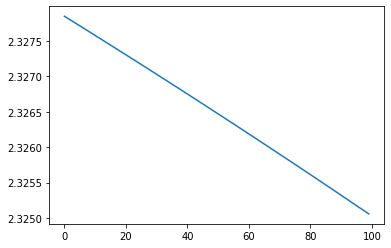



model의 output은 :  [0.0341608  0.03892438 0.19120255 0.18000194 0.00527084 0.00946649
 0.17293252 0.07424279 0.1945276  0.0992701 ]
argmax를 한 후의 output은 8
accuracy는 0.05


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_1

0 2.3046185970306396
10 2.3019232749938965
20 2.299158811569214
30 2.296321392059326
40 2.2934083938598633
50 2.2904152870178223
60 2.287339448928833
70 2.284177541732788
80 2.280926465988159
90 2.277583122253418


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


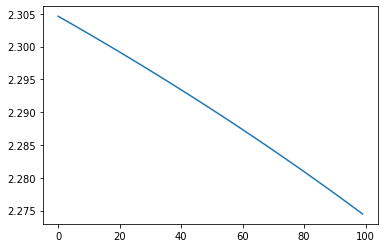



model의 output은 :  [0.17874931 0.06252629 0.13049234 0.02664738 0.03435853 0.05798688
 0.01193481 0.14700902 0.03493078 0.31536463]
argmax를 한 후의 output은 9
accuracy는 0.14629629629629629


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_1

0 2.3039186000823975
10 2.2682323455810547
20 2.224349021911621
30 2.1632328033447266
40 2.0921528339385986
50 2.0222458839416504
60 1.9570726156234741
70 1.9071261882781982
80 1.8673968315124512
90 1.8340028524398804


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


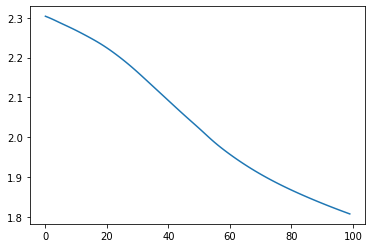



model의 output은 :  [0.01062578 0.8570986  0.01032689 0.00505426 0.00518082 0.00937002
 0.03337749 0.0034116  0.0334384  0.03211623]
argmax를 한 후의 output은 1
accuracy는 0.7611111111111111


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_1

0 2.2991442680358887
10 2.265958309173584
20 2.2442920207977295
30 2.225520372390747
40 2.2090775966644287
50 2.194366216659546
60 2.1809988021850586
70 2.168720245361328


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 2.1573359966278076
90 2.1467268466949463


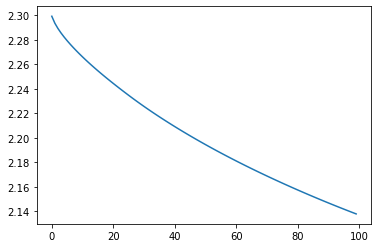



model의 output은 :  [0.12327402 0.10053824 0.04267123 0.15824044 0.12985404 0.03525316
 0.12164808 0.09494842 0.09840446 0.09516787]
argmax를 한 후의 output은 3
accuracy는 0.40185185185185185


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_1

0 2.326737403869629
10 1.959665298461914
20 1.7873393297195435
30 1.7053508758544922
40 1.6593760251998901
50 1.6286476850509644
60 1.6063991785049438
70 1.5896711349487305
80 1.5760245323181152


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.5647401809692383


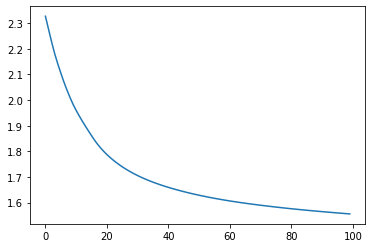



model의 output은 :  [3.1262898e-04 9.7384858e-01 4.5009046e-03 2.4338623e-03 2.2495284e-03
 1.1242168e-02 3.9182613e-03 1.5471971e-05 1.1378697e-03 3.4073202e-04]
argmax를 한 후의 output은 1
accuracy는 0.937037037037037


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_1

0 2.3105030059814453
10 1.591185212135315
20 1.51906418800354
30 1.4878188371658325
40 1.4765626192092896
50 1.473060131072998
60 1.4708170890808105
70 1.4692087173461914
80 1.4683518409729004


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.4678459167480469


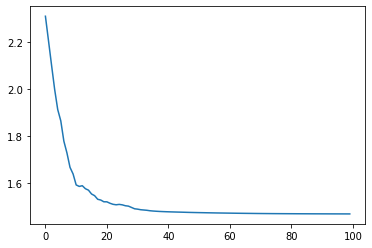



model의 output은 :  [9.9908419e-09 9.9970585e-01 6.1253472e-06 1.7353345e-06 6.4345119e-07
 1.5446401e-06 1.2402018e-04 3.5227390e-11 1.5981287e-04 1.4050239e-07]
argmax를 한 후의 output은 1
accuracy는 0.9648148148148148


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_1

0 2.2959814071655273
10 1.9252735376358032
20 1.7898582220077515
30 1.716210126876831
40 1.6640269756317139
50 1.626372218132019
60 1.6000478267669678
70 1.5798333883285522
80 1.563926339149475


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.5494781732559204


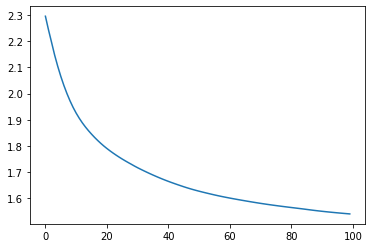



model의 output은 :  [1.2845278e-04 9.8829436e-01 8.2666278e-03 1.8323006e-05 1.6691021e-05
 2.5421444e-03 6.2377140e-04 1.4143267e-05 8.6283871e-05 9.0184312e-06]
argmax를 한 후의 output은 1
accuracy는 0.9592592592592593


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_1

0 2.3024985790252686
10 1.6596723794937134
20 1.5333276987075806
30 1.5068117380142212
40 1.482056975364685
50 1.4767379760742188
60 1.4747196435928345
70 1.4736577272415161
80 1.4788224697113037


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.472266674041748


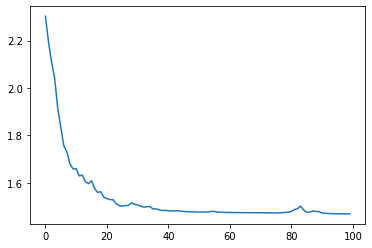



model의 output은 :  [8.0941348e-08 9.9866498e-01 5.1571700e-05 1.7968664e-06 1.1199673e-04
 3.4488454e-05 1.1350580e-03 3.5578093e-08 5.4611920e-08 3.2335763e-08]
argmax를 한 후의 output은 1
accuracy는 0.9629629629629629


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_1

0 2.3075764179229736
10 2.3625030517578125
20 2.3625032901763916
30 2.3625032901763916
40 2.3625032901763916
50 2.3625032901763916
60 2.3625032901763916


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


70 2.3625032901763916
80 2.3625032901763916
90 2.3625032901763916


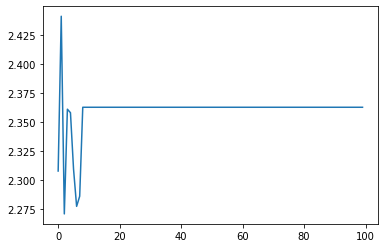



model의 output은 :  [5.4875444e-29 1.9521782e-14 1.0000000e+00 2.3258047e-31 2.3212182e-27
 1.2371059e-18 3.3031661e-15 4.9375883e-17 2.9440717e-27 7.2477921e-24]
argmax를 한 후의 output은 2
accuracy는 0.09814814814814815


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_1

0 2.331488609313965
10 2.2790286540985107
20 2.2078888416290283
30 2.133883476257324
40 2.061673164367676
50 1.9946863651275635
60 1.9348021745681763
70 1.8809056282043457


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 1.8325663805007935
90 1.789388656616211


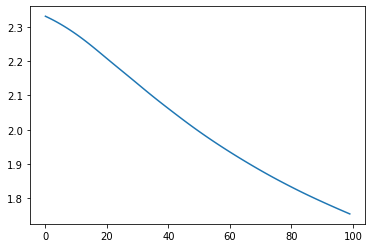



model의 output은 :  [0.02524673 0.61648244 0.06886379 0.0483492  0.059164   0.085485
 0.06286516 0.01440941 0.01374832 0.00538589]
argmax를 한 후의 output은 1
accuracy는 0.8055555555555556


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_1

0 2.3004283905029297
10 1.7947657108306885
20 1.591744065284729
30 1.5242230892181396
40 1.4946177005767822
50 1.4823551177978516
60 1.4760937690734863
70 1.4725077152252197


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 1.4705995321273804
90 1.4696094989776611


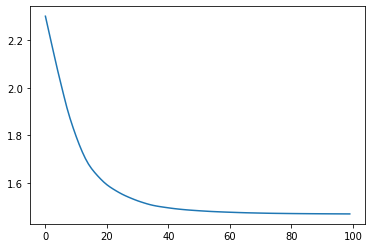



model의 output은 :  [1.5821932e-08 9.9997473e-01 7.9320143e-06 7.7669972e-07 1.6435930e-06
 5.3567242e-06 8.4393622e-07 5.3344351e-10 4.8496975e-07 8.1534981e-06]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_1

0 2.3119215965270996
10 1.5499615669250488
20 1.4956892728805542
30 1.4861880540847778
40 1.4744842052459717
50 1.473558783531189
60 1.4723968505859375


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


70 1.4737484455108643
80 1.4918752908706665
90 1.4872909784317017


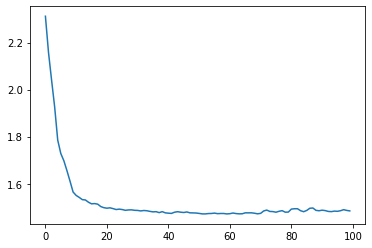



model의 output은 :  [4.2792422e-07 9.9924242e-01 2.9393236e-04 2.2221911e-15 1.8665844e-12
 2.7511298e-04 1.8710671e-04 5.8745809e-23 9.3609526e-07 8.0418324e-15]
argmax를 한 후의 output은 1
accuracy는 0.95


In [24]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_1\n')
        model = Model()
        model.apply(init_weights_x)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()

        losses = []
        # 모델 학습
        for epoch in range(100):
            optimizer.zero_grad()
            hypothesis = model(x_train) # 순전파 연산

            # 비용 함수
            cost = loss_fn(hypothesis, y_train)
            cost.backward() # 역전파 연산
            optimizer.step() # 기울기 업데이트
            losses.append(cost.item()) # 1 epoch 당 손실점수 저장

            if epoch % 10 == 0:
                print(epoch, cost.item()) # 손실점수 산출
        
        plt.plot(losses)
        plt.show()
        print('\n')

        # 모델 평가(검증)
        with torch.no_grad(): # 모델 평가 연산에서는 grad 값 불필요
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy() # 계산 정보 기억 X, 넘파이 연산 가능하도록 변환
            predicted = np.argmax(y_pred, axis =1) # 행 방향으로 최댓값의 인덱스 값 저장
            accuracy = (accuracy_score(predicted, y_test))
        
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')

        row = {'epoch': epoch, 'model': 'model_1', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True) # 반복문 실행하여 평가 점수 데이터프레임에 저장

2. hidden layer 수: 1, tanh 활용

In [25]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 25, bias=True),
                                    nn.Tanh(),
                                    nn.BatchNorm1d(25))
        self.layer2 = nn.Sequential(nn.Linear(25, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        return output



최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_2

0 2.301677942276001
10 2.3009467124938965
20 2.3002233505249023
30 2.2995073795318604
40 2.298800468444824
50 2.2981040477752686
60 2.2974181175231934
70 2.2967426776885986
80 2.296078681945801
90 2.295423984527588


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


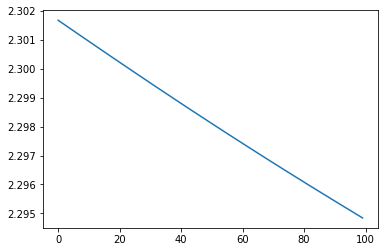



model의 output은 :  [0.00276639 0.04323982 0.0018494  0.01488766 0.0876643  0.01205128
 0.28727272 0.20029135 0.03562503 0.31435207]
argmax를 한 후의 output은 9
accuracy는 0.15925925925925927


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_2

0 2.309093952178955
10 2.305935859680176
20 2.3026840686798096
30 2.2993383407592773
40 2.2958405017852783
50 2.2920968532562256
60 2.2879953384399414
70 2.283447742462158
80 2.278451919555664
90 2.273178815841675


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


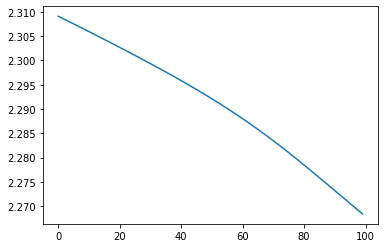



model의 output은 :  [2.5494286e-01 8.0582092e-04 1.4607905e-04 2.6504109e-05 1.4938861e-02
 6.3464475e-01 3.3564605e-02 1.3483246e-02 6.7626457e-03 4.0684689e-02]
argmax를 한 후의 output은 5
accuracy는 0.18888888888888888


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_2

0 2.315941333770752
10 2.2753279209136963
20 2.222217559814453
30 2.1632704734802246
40 2.0937817096710205
50 2.0428168773651123
60 1.999065637588501
70 1.9586693048477173
80 1.9195359945297241
90 1.8840996026992798


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


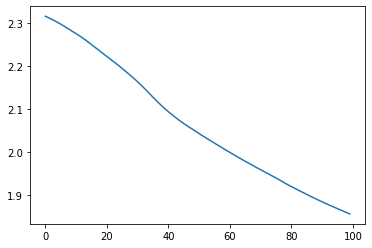



model의 output은 :  [0.01090607 0.16292767 0.19099943 0.14055555 0.06544062 0.02500023
 0.06586904 0.00220565 0.28997555 0.04612015]
argmax를 한 후의 output은 8
accuracy는 0.7185185185185186


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_2

0 2.299403667449951
10 2.265404462814331
20 2.2447783946990967
30 2.229182243347168
40 2.2166829109191895
50 2.206350803375244
60 2.1975061893463135
70 2.189596652984619
80 2.182429790496826
90 2.1758689880371094


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


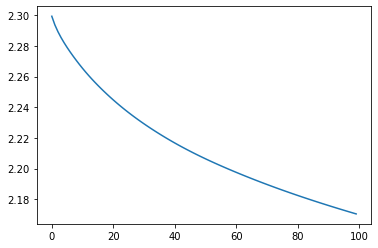



model의 output은 :  [4.8372429e-04 9.8209918e-01 3.0162057e-04 3.1851979e-03 3.7877487e-03
 2.6494898e-03 1.3929931e-03 1.4301966e-03 1.0669983e-04 4.5631710e-03]
argmax를 한 후의 output은 1
accuracy는 0.3351851851851852


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_2

0 2.315627098083496
10 2.023519515991211
20 1.8853535652160645
30 1.7792609930038452
40 1.7082688808441162
50 1.6646952629089355
60 1.631915807723999
70 1.6081156730651855
80 1.5918461084365845
90 1.5798909664154053


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


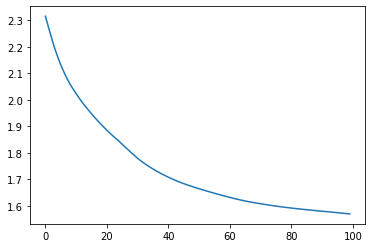



model의 output은 :  [1.2245374e-03 9.4364756e-01 1.6265234e-02 2.3215055e-03 4.8212172e-04
 6.7413920e-03 2.3377456e-02 2.0347766e-03 3.6647192e-03 2.4070858e-04]
argmax를 한 후의 output은 1
accuracy는 0.9296296296296296


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_2

0 2.3294529914855957
10 1.66713547706604
20 1.5443538427352905
30 1.5067020654678345
40 1.4879778623580933
50 1.4813892841339111
60 1.4763425588607788
70 1.4725931882858276
80 1.471687912940979


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.4710240364074707


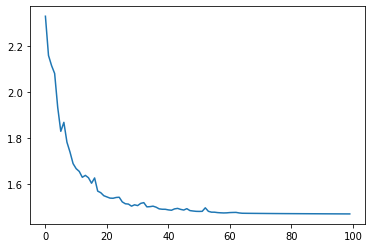



model의 output은 :  [1.1760743e-08 9.9997365e-01 2.2122401e-06 1.7861247e-07 9.4675450e-08
 7.4920585e-08 4.0871132e-08 4.2836255e-08 7.1233976e-06 1.6402661e-05]
argmax를 한 후의 output은 1
accuracy는 0.9574074074074074


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_2

0 2.2930796146392822
10 1.9584945440292358
20 1.8479623794555664
30 1.7706830501556396
40 1.71473228931427
50 1.6747463941574097
60 1.6448713541030884
70 1.6194976568222046
80 1.598582148551941


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.582934856414795


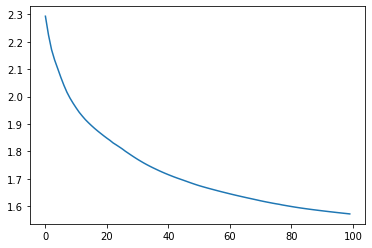



model의 output은 :  [5.5123526e-03 8.9218396e-01 7.1194597e-02 2.3374849e-03 2.9930379e-04
 1.9685184e-03 1.2372449e-02 3.9768343e-05 1.2694048e-02 1.3974523e-03]
argmax를 한 후의 output은 1
accuracy는 0.9166666666666666


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_2

0 2.327881336212158
10 1.7977163791656494
20 1.6283233165740967
30 1.5661063194274902
40 1.5277215242385864
50 1.5136841535568237
60 1.5079917907714844
70 1.4889395236968994
80 1.488303780555725


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.4807502031326294


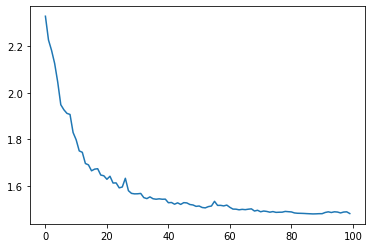



model의 output은 :  [1.0595574e-07 9.9341398e-01 1.6201014e-04 7.1490327e-08 8.3647370e-07
 6.0329381e-05 1.4587532e-03 1.0150257e-09 1.1014634e-04 4.7938568e-03]
argmax를 한 후의 output은 1
accuracy는 0.9537037037037037


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_2

0 2.296255111694336
10 2.3608975410461426
20 2.360877275466919
30 2.3625030517578125
40 2.3625030517578125
50 2.3625030517578125
60 2.3625030517578125
70 2.3625030517578125
80 2.3625030517578125


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 2.3625030517578125


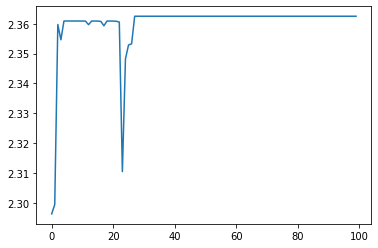



model의 output은 :  [9.99998569e-01 8.53110204e-20 1.94472101e-21 2.17389424e-19
 1.47903961e-06 3.30395457e-23 1.27237022e-15 1.10423345e-20
 7.96671491e-26 3.36341336e-18]
argmax를 한 후의 output은 0
accuracy는 0.1


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_2

0 2.3173305988311768
10 2.260268211364746
20 2.1925666332244873
30 2.1179537773132324
40 2.0453641414642334
50 1.9714596271514893
60 1.9059804677963257
70 1.8498204946517944
80 1.8041313886642456


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.7646950483322144


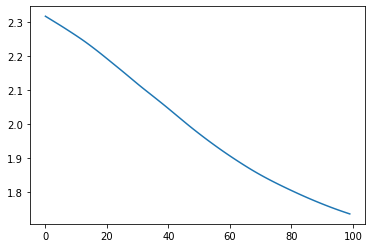



model의 output은 :  [0.00359572 0.00808566 0.14562596 0.17546465 0.12470892 0.04472871
 0.12376791 0.011316   0.33499494 0.02771155]
argmax를 한 후의 output은 8
accuracy는 0.8277777777777777


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_2

0 2.313960552215576
10 1.869134783744812
20 1.667440414428711
30 1.552178144454956
40 1.5119819641113281
50 1.4945305585861206
60 1.4871774911880493
70 1.4823083877563477


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 1.4786115884780884
90 1.4759502410888672


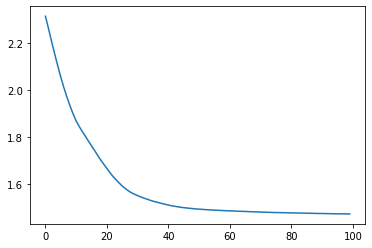



model의 output은 :  [4.8596597e-05 9.8159319e-01 4.8656473e-03 3.5915352e-06 1.0397126e-04
 2.0570384e-05 3.2977953e-03 1.1812244e-06 9.8424591e-03 2.2289740e-04]
argmax를 한 후의 output은 1
accuracy는 0.9611111111111111


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_2

0 2.337841510772705
10 1.652992606163025
20 1.6032649278640747
30 1.5964419841766357
40 1.5918031930923462
50 1.5876550674438477
60 1.5892797708511353
70 1.579024314880371
80 1.5834178924560547


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.6027092933654785


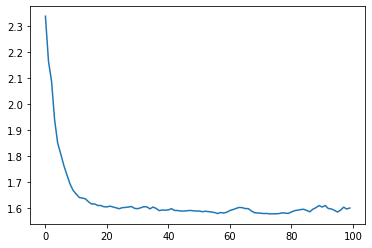



model의 output은 :  [9.1957515e-21 9.9996030e-01 1.6334956e-09 4.4331528e-23 1.5986559e-17
 5.2875794e-06 3.4412991e-05 4.8604201e-24 1.2251012e-09 6.1570321e-15]
argmax를 한 후의 output은 1
accuracy는 0.8462962962962963


In [26]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_2\n')
        model = Model()
        model.apply(init_weights_x)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            cost = loss_fn(model(x_train), y_train)
            cost.backward()
            optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_2', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

3. hidden layer 수: 1, ReLU 활용

In [27]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 25, bias=True),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(25))
        self.layer2 = nn.Sequential(nn.Linear(25, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        return output



최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_3

0 2.2527778148651123
10 2.2520551681518555
20 2.2513256072998047
30 2.2505905628204346
40 2.2498488426208496
50 2.249102830886841
60 2.248347759246826
70 2.247584104537964
80 2.2468173503875732


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 2.24605131149292


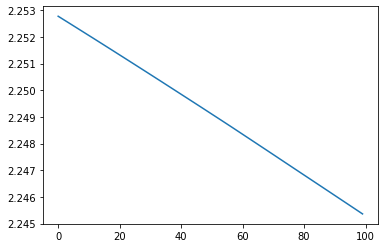



model의 output은 :  [2.1780975e-04 7.9289740e-01 2.4746198e-04 1.6419308e-02 1.0328852e-03
 7.9988586e-03 1.4399236e-01 2.0158023e-03 3.3367615e-02 1.8104231e-03]
argmax를 한 후의 output은 1
accuracy는 0.2537037037037037


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_3

0 2.3163986206054688
10 2.313297748565674
20 2.3098652362823486
30 2.3062801361083984
40 2.302696943283081
50 2.299034357070923
60 2.2952463626861572
70 2.2913126945495605
80 2.2872207164764404
90 2.2828738689422607


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


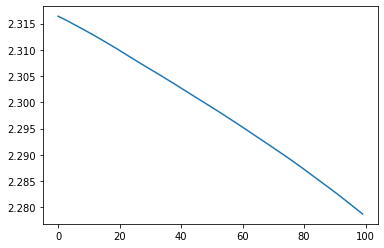



model의 output은 :  [0.19006927 0.2540634  0.06850836 0.04703677 0.03945522 0.02176005
 0.03174072 0.21422113 0.06736512 0.06578006]
argmax를 한 후의 output은 1
accuracy는 0.16111111111111112


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_3

0 2.3446271419525146
10 2.324700117111206
20 2.2961039543151855
30 2.253666877746582
40 2.198678970336914
50 2.138669013977051
60 2.0783865451812744
70 2.0256195068359375
80 1.9751667976379395
90 1.934322714805603


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


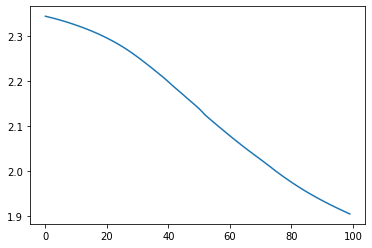



model의 output은 :  [5.9370312e-05 1.7558658e-02 8.0846876e-01 1.2195214e-02 5.0318980e-04
 1.4920749e-02 2.5750298e-02 3.1826406e-04 1.0340492e-01 1.6820621e-02]
argmax를 한 후의 output은 2
accuracy는 0.662962962962963


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_3

0 2.2989044189453125
10 2.27150559425354
20 2.2551517486572266
30 2.24179744720459
40 2.2299182415008545
50 2.219135284423828
60 2.209202289581299
70 2.1996688842773438
80 2.1905927658081055


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 2.181942939758301


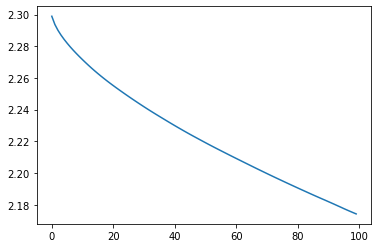



model의 output은 :  [0.00861802 0.724307   0.07243615 0.01319919 0.01444989 0.00323908
 0.03269752 0.00762111 0.10389223 0.01953969]
argmax를 한 후의 output은 1
accuracy는 0.3425925925925926


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_3

0 2.3063197135925293
10 1.9441763162612915
20 1.7990401983261108
30 1.7174456119537354
40 1.6705352067947388
50 1.6398234367370605
60 1.617316484451294
70 1.6000553369522095


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 1.5863758325576782
90 1.5748801231384277


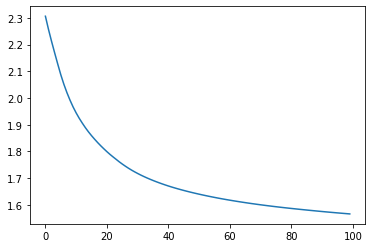



model의 output은 :  [0.0030641  0.7696735  0.18002364 0.00325027 0.00259067 0.0058097
 0.02582199 0.00088006 0.00449723 0.00438885]
argmax를 한 후의 output은 1
accuracy는 0.9388888888888889


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_3

0 2.315305233001709
10 1.52451753616333
20 1.4912694692611694
30 1.480061411857605
40 1.4742177724838257
50 1.4703922271728516
60 1.4681899547576904
70 1.4669798612594604
80 1.4662723541259766


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.465786099433899


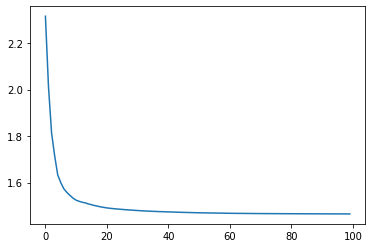



model의 output은 :  [8.8666086e-10 9.9990916e-01 3.0294422e-07 1.7188076e-07 2.9679051e-05
 2.6936888e-05 3.2515181e-05 1.2971782e-12 1.3051374e-06 7.3653603e-09]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_3

0 2.3075289726257324
10 1.9517426490783691
20 1.802531361579895
30 1.7179392576217651
40 1.6670184135437012
50 1.63125479221344
60 1.605772852897644
70 1.5867698192596436
80 1.5717298984527588


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


90 1.5595546960830688


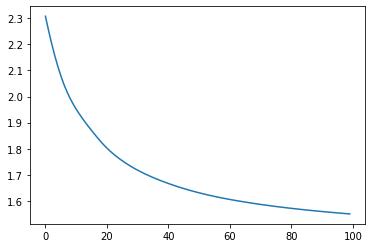



model의 output은 :  [9.5276028e-04 9.5313382e-01 2.2888532e-02 2.4282644e-03 4.5075564e-04
 6.0754567e-03 9.0339445e-03 4.0057767e-04 3.6153425e-03 1.0204423e-03]
argmax를 한 후의 output은 1
accuracy는 0.9462962962962963


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_3

0 2.302124261856079
10 1.5347272157669067
20 1.4907845258712769
30 1.4777488708496094
40 1.4731106758117676
50 1.4708092212677002
60 1.4695714712142944
70 1.4688503742218018


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 1.4683659076690674
90 1.468029260635376


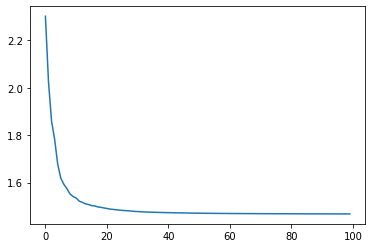



model의 output은 :  [7.9396596e-09 9.9988210e-01 5.6838981e-05 1.6008557e-06 6.0440038e-06
 2.9039260e-05 9.1613202e-07 1.0212663e-09 3.5115747e-06 1.9961473e-05]
argmax를 한 후의 output은 1
accuracy는 0.9648148148148148


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_3

0 2.321622848510742
10 1.986819863319397
20 1.8773959875106812
30 1.8034963607788086
40 1.7792332172393799
50 1.7695834636688232
60 1.7641546726226807


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


70 1.666380763053894
80 1.6630181074142456
90 1.662697672843933


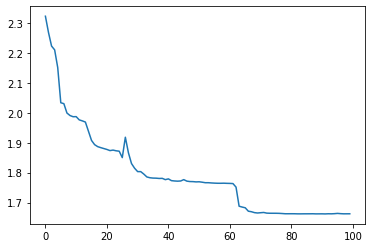



model의 output은 :  [8.4642943e-30 1.0000000e+00 8.6426986e-16 1.3743043e-37 2.8096071e-19
 1.7110106e-27 7.8513319e-32 7.1779270e-33 1.5013687e-20 3.0239143e-30]
argmax를 한 후의 output은 1
accuracy는 0.7814814814814814


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_3

0 2.2967758178710938
10 2.2420642375946045
20 2.179821252822876
30 2.1234591007232666
40 2.0672690868377686
50 2.019017457962036
60 1.9780677556991577
70 1.9411629438400269


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 1.9099191427230835
90 1.8837708234786987


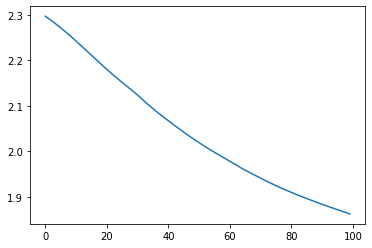



model의 output은 :  [0.01358582 0.46415642 0.14404915 0.01049413 0.01156672 0.06062679
 0.13819088 0.00454503 0.14543436 0.00735072]
argmax를 한 후의 output은 1
accuracy는 0.6555555555555556


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_3

0 2.3082640171051025
10 1.833320140838623
20 1.6177209615707397
30 1.5458576679229736
40 1.5165064334869385
50 1.5019524097442627
60 1.4875558614730835
70 1.4797903299331665


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 1.4752200841903687
90 1.472434401512146


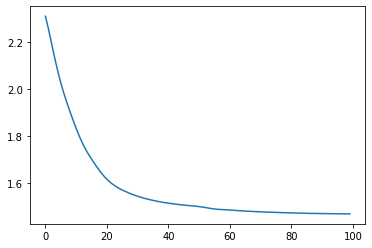



model의 output은 :  [2.9093764e-10 9.9994683e-01 9.4429088e-06 2.0822092e-07 1.2476776e-06
 1.1486486e-06 1.6197057e-06 3.3530623e-10 3.9463153e-05 2.5607092e-09]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_3

0 2.3092591762542725
10 1.5966169834136963
20 1.572604775428772
30 1.5690648555755615
40 1.5670161247253418
50 1.5405958890914917
60 1.4816229343414307
70 1.4729745388031006


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


80 1.4684128761291504
90 1.4654552936553955


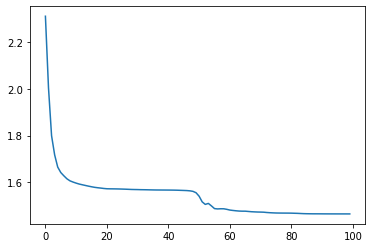



model의 output은 :  [5.6015983e-24 9.9999976e-01 3.5382362e-14 3.2398170e-13 2.6241267e-15
 1.2816566e-15 1.3130796e-07 1.2309511e-21 5.2271254e-08 7.6275721e-13]
argmax를 한 후의 output은 1
accuracy는 0.9703703703703703


In [28]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_3\n')
        model = Model()
        model.apply(init_weights_h)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            cost = loss_fn(model(x_train), y_train)
            cost.backward()
            optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_3', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

4. hidden layer 수: 2, sigmoid 활용

In [29]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 100, bias=True),
                                    nn.Sigmoid(),
                                    nn.BatchNorm1d(100))
        self.layer2 = nn.Sequential(nn.Linear(100, 30, bias=True),
                                    nn.Sigmoid())
        self.layer3 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        return output



최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_4

0 2.3073298931121826
10 2.3072643280029297
20 2.3071987628936768
30 2.3071324825286865
40 2.3070666790008545
50 2.3070008754730225


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.3069348335266113
70 2.3068692684173584
80 2.30680251121521
90 2.306736469268799


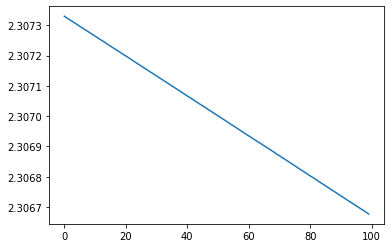



model의 output은 :  [0.27262712 0.09907531 0.05792057 0.03325572 0.05109663 0.10906842
 0.03505884 0.11675815 0.0889897  0.13614953]
argmax를 한 후의 output은 0
accuracy는 0.08148148148148149


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_4

0 2.308272361755371
10 2.307512044906616
20 2.3067386150360107
30 2.305952787399292
40 2.3051531314849854
50 2.30433988571167


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.3035128116607666
70 2.3026716709136963
80 2.301816463470459
90 2.3009469509124756


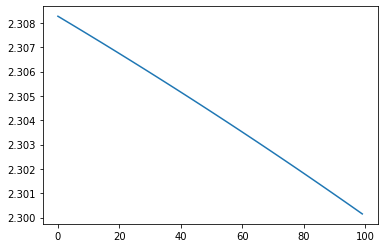



model의 output은 :  [0.09321328 0.1490603  0.17694663 0.07195704 0.0420518  0.05772331
 0.10101033 0.17658576 0.03426077 0.09719083]
argmax를 한 후의 output은 2
accuracy는 0.12962962962962962


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_4

0 2.305294990539551
10 2.299848794937134
20 2.2938222885131836
30 2.287163734436035
40 2.2798712253570557
50 2.272071599960327


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.2638087272644043
70 2.255034923553467
80 2.24568772315979
90 2.2357072830200195


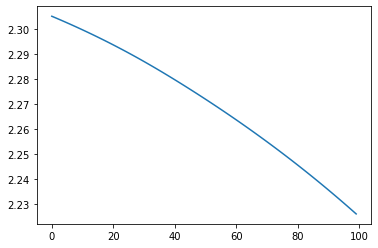



model의 output은 :  [0.0176664  0.1110859  0.21413447 0.04499616 0.11912235 0.20839949
 0.06134262 0.08103812 0.02691088 0.11530363]
argmax를 한 후의 output은 2
accuracy는 0.387037037037037


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_4

0 2.305850028991699
10 2.276611566543579
20 2.2580320835113525
30 2.242249011993408
40 2.228012800216675
50 2.2148327827453613


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.2025136947631836
70 2.190984010696411
80 2.1801977157592773
90 2.170109987258911


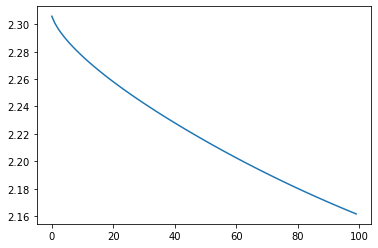



model의 output은 :  [0.03907821 0.07972883 0.37874556 0.01809419 0.12395181 0.11210515
 0.04469235 0.02670328 0.0840471  0.09285355]
argmax를 한 후의 output은 2
accuracy는 0.4703703703703704


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_4

0 2.3035385608673096
10 1.9411879777908325
20 1.8070846796035767
30 1.727419376373291
40 1.6677659749984741
50 1.6200789213180542


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.589582085609436
70 1.5687071084976196
80 1.553394079208374
90 1.5418158769607544


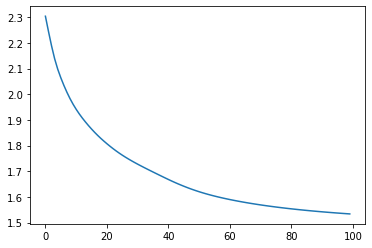



model의 output은 :  [0.0024003  0.8832687  0.05759221 0.00794125 0.00744583 0.00120919
 0.00676352 0.0077127  0.01447594 0.0111903 ]
argmax를 한 후의 output은 1
accuracy는 0.975925925925926


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_4

0 2.3112611770629883
10 1.7293556928634644
20 1.5873769521713257
30 1.5311709642410278
40 1.4855992794036865
50 1.4726648330688477


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4672952890396118
70 1.4663056135177612
80 1.4656816720962524
90 1.465247392654419


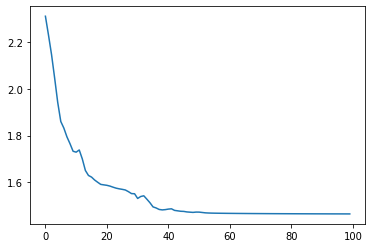



model의 output은 :  [2.0263619e-06 9.9865973e-01 9.2166018e-05 1.6733048e-04 3.0782068e-04
 2.0763902e-05 2.9850315e-04 9.7669770e-05 1.9199487e-04 1.6199338e-04]
argmax를 한 후의 output은 1
accuracy는 0.9777777777777777


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_4

0 2.314784526824951
10 2.023158550262451
20 1.830230951309204
30 1.7113748788833618
40 1.6460247039794922
50 1.604927659034729


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.5771318674087524
70 1.5570073127746582
80 1.5420273542404175
90 1.5306252241134644


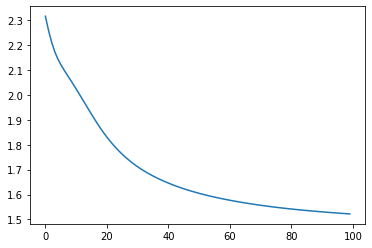



model의 output은 :  [0.00337976 0.92821753 0.0182173  0.00277658 0.0084803  0.0022436
 0.01337167 0.0066826  0.01214659 0.00448401]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_4

0 2.3027310371398926
10 1.686388611793518
20 1.556917428970337
30 1.4830085039138794
40 1.4739924669265747
50 1.4694300889968872


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4675143957138062
70 1.4665366411209106
80 1.4656957387924194
90 1.4648549556732178


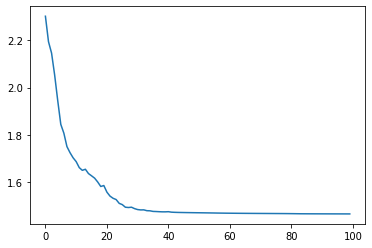



model의 output은 :  [8.8763300e-06 9.9850357e-01 8.9931113e-05 2.5933835e-04 3.8296703e-04
 4.3018881e-05 2.1298663e-04 7.5871885e-06 3.2945603e-04 1.6240175e-04]
argmax를 한 후의 output은 1
accuracy는 0.9685185185185186


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_4

0 2.307790517807007
10 2.3616788387298584
20 2.3616788387298584


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


30 2.3616788387298584
40 2.3616788387298584
50 2.3616788387298584
60 2.3616788387298584
70 2.3616788387298584
80 2.3616788387298584
90 2.3616788387298584


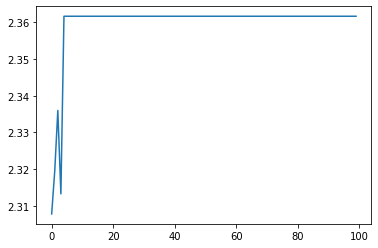



model의 output은 :  [3.9402980e-14 3.6066122e-10 9.1072526e-17 4.1222407e-08 7.4471441e-17
 2.2428660e-15 5.1060692e-12 1.0000000e+00 1.0819350e-14 2.4205635e-12]
argmax를 한 후의 output은 7
accuracy는 0.1


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_4

0 2.29829478263855
10 2.228219509124756
20 2.1548914909362793
30 2.0863027572631836
40 2.019726276397705
50 1.9527008533477783


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.8890011310577393
70 1.832068920135498
80 1.783414602279663
90 1.7437258958816528


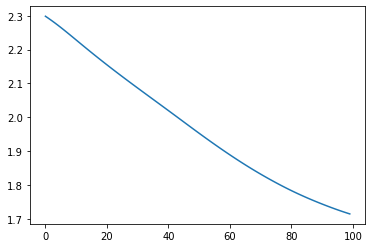



model의 output은 :  [8.6952923e-03 8.3837932e-01 2.8421547e-02 3.1696390e-02 2.2337727e-02
 3.3682000e-02 1.1479154e-02 8.1045330e-03 8.1980566e-04 1.6384315e-02]
argmax를 한 후의 output은 1
accuracy는 0.8814814814814815


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_4

0 2.3081815242767334
10 1.8885082006454468
20 1.716507077217102
30 1.6106715202331543
40 1.5757131576538086


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


50 1.5663836002349854
60 1.5619590282440186
70 1.559744954109192
80 1.5579553842544556
90 1.5531022548675537


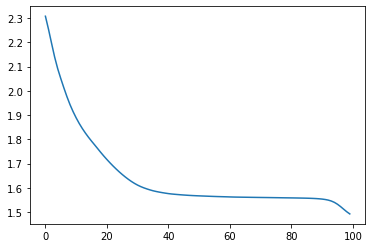



model의 output은 :  [3.61440645e-04 9.97250021e-01 1.11007714e-04 3.67214641e-04
 3.16944410e-04 3.16219783e-04 1.09872657e-04 2.55506398e-04
 5.80422871e-04 3.31366115e-04]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_4

0 2.309046983718872
10 1.603733777999878
20 1.572751522064209
30 1.5627732276916504


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.5611177682876587
50 1.5624887943267822
60 1.5618983507156372
70 1.5635770559310913
80 1.564801573753357
90 1.5634891986846924


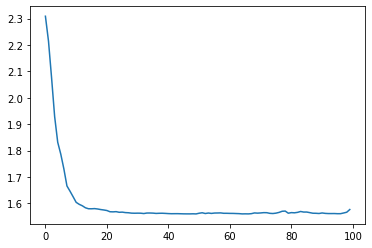



model의 output은 :  [1.00289864e-04 9.99221325e-01 3.86979256e-04 1.28520450e-09
 3.74878255e-06 3.94368726e-06 2.79319851e-04 1.73339049e-06
 9.73170984e-08 2.44488297e-06]
argmax를 한 후의 output은 1
accuracy는 0.8759259259259259


In [30]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_4\n')
        model = Model()
        model.apply(init_weights_x)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            cost = loss_fn(model(x_train), y_train)
            cost.backward()
            optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_4', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

5. hidden layer 수: 2, tanh 활용


In [31]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 100, bias=True),
                                    nn.Tanh(),
                                    nn.BatchNorm1d(100))
        self.layer2 = nn.Sequential(nn.Linear(100, 30, bias=True),
                                    nn.Tanh())
        self.layer3 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        return output



최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_5

0 2.297119140625
10 2.2965152263641357
20 2.2959041595458984
30 2.295286178588867
40 2.2946605682373047
50 2.2940280437469482
60 2.2933883666992188


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


70 2.292741537094116
80 2.2920873165130615
90 2.291426181793213


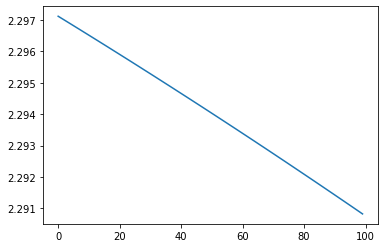



model의 output은 :  [0.02838983 0.0493834  0.09261549 0.15683755 0.10155703 0.21669593
 0.16895594 0.06737119 0.08011833 0.03807527]
argmax를 한 후의 output은 5
accuracy는 0.12777777777777777


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_5

0 2.311845541000366
10 2.3069136142730713
20 2.3015830516815186
30 2.2958593368530273
40 2.289764881134033
50 2.2833127975463867


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.276502847671509
70 2.2693228721618652
80 2.2617642879486084
90 2.253843069076538


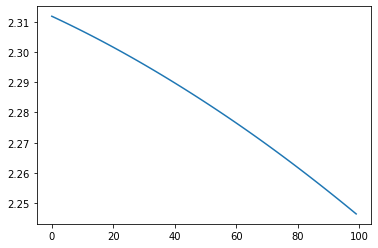



model의 output은 :  [0.03946674 0.11222995 0.05321621 0.05235839 0.03321459 0.02480653
 0.09035968 0.17534812 0.26886368 0.15013617]
argmax를 한 후의 output은 8
accuracy는 0.26481481481481484


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_5

0 2.318105459213257
10 2.249342441558838
20 2.1568572521209717
30 2.0720160007476807
40 1.9983716011047363
50 1.935804843902588
60 1.8810356855392456


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


70 1.8337105512619019
80 1.7929097414016724
90 1.7577085494995117


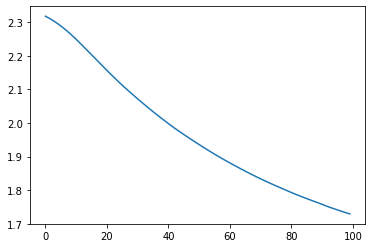



model의 output은 :  [0.0097462  0.49290636 0.04293117 0.00499018 0.00644277 0.07707057
 0.33117482 0.01769366 0.01388605 0.00315824]
argmax를 한 후의 output은 1
accuracy는 0.8333333333333334


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_5

0 2.3133926391601562
10 2.213120698928833
20 2.13979434967041
30 2.0819594860076904
40 2.035593271255493
50 1.9976308345794678


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.9653799533843994
70 1.9378647804260254
80 1.9139519929885864
90 1.893017053604126


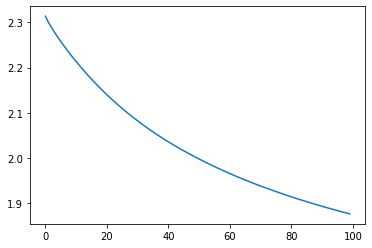



model의 output은 :  [0.01753195 0.354209   0.13027637 0.05608802 0.01464119 0.07543842
 0.05021358 0.05881909 0.13324967 0.10953265]
argmax를 한 후의 output은 1
accuracy는 0.8055555555555556


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_5

0 2.2989158630371094
10 1.6203789710998535
20 1.5402344465255737
30 1.5107754468917847
40 1.4956986904144287
50 1.4875901937484741


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4825884103775024
70 1.4786220788955688
80 1.475541114807129
90 1.473412036895752


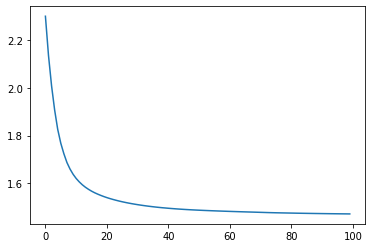



model의 output은 :  [2.1645695e-04 9.9169672e-01 2.7078299e-03 7.6310360e-04 1.9764192e-04
 1.5634592e-03 6.8026292e-04 3.5229381e-04 7.8061468e-04 1.0415907e-03]
argmax를 한 후의 output은 1
accuracy는 0.9740740740740741


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_5

0 2.296968460083008
10 1.6231608390808105
20 1.5143030881881714
30 1.4822131395339966
40 1.4677302837371826
50 1.4654539823532104


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4649529457092285
70 1.4646660089492798
80 1.464480996131897
90 1.4643549919128418


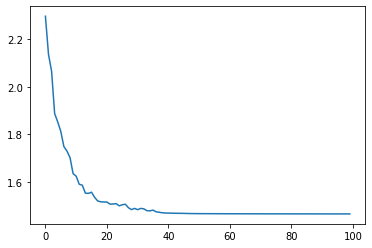



model의 output은 :  [2.44469618e-08 9.97938573e-01 1.86638883e-03 1.45150307e-06
 2.23664065e-05 7.04460035e-07 5.65086266e-05 2.38023532e-07
 1.04073435e-04 9.66940388e-06]
argmax를 한 후의 output은 1
accuracy는 0.9685185185185186


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_5

0 2.3047447204589844
10 1.620406150817871
20 1.5374062061309814
30 1.5095285177230835
40 1.496085286140442
50 1.4860973358154297


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4800958633422852
70 1.476317048072815
80 1.4735608100891113
90 1.4714874029159546


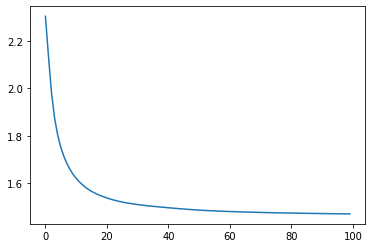



model의 output은 :  [1.09306064e-04 9.88510072e-01 1.40517496e-03 3.98112781e-04
 3.72719078e-04 3.12959455e-04 8.24892311e-04 2.33050645e-03
 5.35053248e-03 3.85803811e-04]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_5

0 2.321415662765503
10 1.6126954555511475
20 1.5397462844848633
30 1.4979521036148071
40 1.4797768592834473
50 1.4703174829483032


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4673014879226685
70 1.466474175453186
80 1.4659031629562378
90 1.4655579328536987


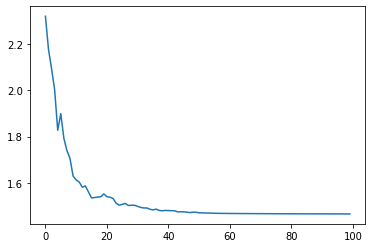



model의 output은 :  [4.31593890e-08 9.98910189e-01 6.58880279e-04 5.28924793e-05
 3.19849710e-06 1.01237114e-04 9.12464020e-05 1.08768802e-06
 7.73663633e-05 1.03907558e-04]
argmax를 한 후의 output은 1
accuracy는 0.9555555555555556


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_5

0 2.314051389694214
10 2.3640754222869873
20 2.360116720199585
30 2.360116720199585
40 2.360116720199585
50 2.360116720199585


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.360116720199585
70 2.360116720199585
80 2.360116720199585
90 2.360116720199585


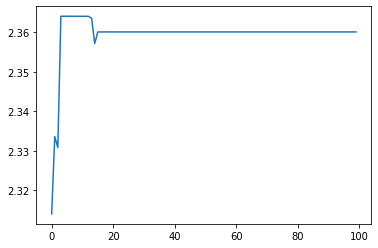



model의 output은 :  [4.8640295e-15 2.8236762e-16 2.0768536e-15 5.5119144e-17 1.0088632e-21
 1.0000000e+00 1.6149718e-21 7.4674608e-23 2.3949790e-16 1.1143424e-16]
argmax를 한 후의 output은 5
accuracy는 0.10185185185185185


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_5

0 2.3155357837677
10 2.1309397220611572
20 1.9478400945663452
30 1.8173893690109253
40 1.7172037363052368
50 1.6418536901474


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.5899876356124878
70 1.5559618473052979
80 1.5335599184036255
90 1.518373966217041


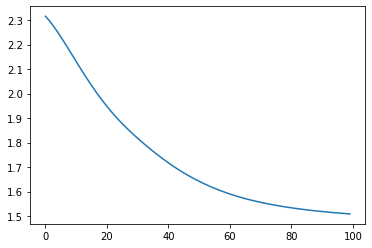



model의 output은 :  [1.9896332e-04 9.6546215e-01 1.2915596e-02 2.7947561e-03 2.9605639e-03
 1.0572638e-02 2.0693243e-03 3.1136975e-04 8.8458206e-04 1.8302259e-03]
argmax를 한 후의 output은 1
accuracy는 0.9611111111111111


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_5

0 2.3167994022369385
10 1.5678136348724365
20 1.4848328828811646
30 1.4714823961257935
40 1.4668552875518799
50 1.4647016525268555


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4630753993988037
70 1.462049961090088
80 1.4618306159973145
90 1.4617010354995728


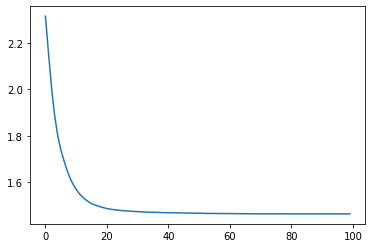



model의 output은 :  [6.1513714e-07 9.9952567e-01 3.0517767e-04 5.5132859e-05 1.6041180e-05
 2.2005106e-05 2.2092496e-05 1.3695588e-06 4.4746801e-05 7.1061913e-06]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_5

0 2.2892062664031982
10 1.5465679168701172
20 1.5116404294967651
30 1.4993771314620972
40 1.5043730735778809
50 1.499672770500183


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.513512134552002
70 1.523489236831665
80 1.5511709451675415
90 1.546830177307129


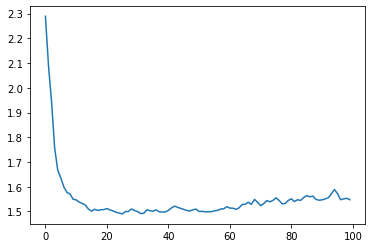



model의 output은 :  [1.0698145e-11 9.6683961e-01 2.6149593e-02 7.4173348e-11 4.1084697e-08
 1.6207678e-11 3.5229604e-07 7.2843004e-14 7.0103477e-03 8.4813510e-12]
argmax를 한 후의 output은 1
accuracy는 0.8944444444444445


In [32]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_5\n')
        model = Model()
        model.apply(init_weights_x)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            cost = loss_fn(model(x_train), y_train)
            cost.backward()
            optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_5', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

6. hidden layer 수: 2, ReLU 활용


In [33]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 100, bias=True),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(100))
        self.layer2 = nn.Sequential(nn.Linear(100, 30, bias=True),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        return output



최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_6

0 2.3423757553100586
10 2.3421642780303955
20 2.3419525623321533
30 2.341740131378174
40 2.3415262699127197
50 2.34131121635437


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.341094970703125
70 2.3408775329589844
80 2.340657949447632
90 2.340437173843384


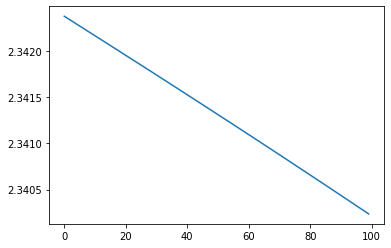



model의 output은 :  [0.0166849  0.00096798 0.05284927 0.01456687 0.0127068  0.00863609
 0.00147066 0.39063656 0.3812558  0.12022508]
argmax를 한 후의 output은 7
accuracy는 0.07407407407407407


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_6

0 2.3015851974487305
10 2.295569896697998
20 2.289245367050171
30 2.282602071762085
40 2.275631904602051
50 2.2683122158050537
60 2.2606306076049805


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


70 2.252614736557007
80 2.244276285171509
90 2.235820770263672


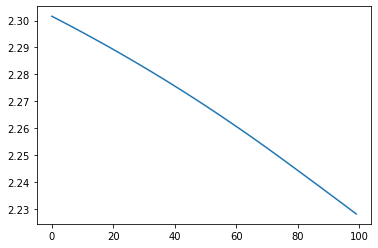



model의 output은 :  [1.6388493e-02 1.7219735e-02 8.4206956e-03 8.8266219e-04 9.6394662e-03
 8.6856073e-01 4.7085512e-02 2.8673489e-02 2.5487768e-03 5.8046437e-04]
argmax를 한 후의 output은 5
accuracy는 0.2851851851851852


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_6

0 2.331859827041626
10 2.294261932373047
20 2.2310991287231445
30 2.1432294845581055
40 2.0491342544555664
50 1.9544957876205444


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.882668375968933
70 1.822235345840454
80 1.7593727111816406
90 1.7070926427841187


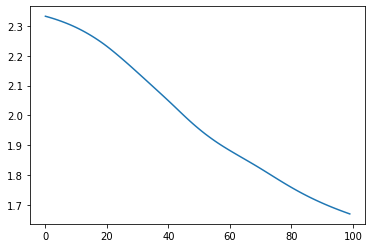



model의 output은 :  [4.1353001e-04 9.5952773e-01 1.0773999e-03 4.8449254e-03 9.3991309e-03
 1.9956606e-03 7.0594967e-04 2.3506154e-04 2.1148641e-02 6.5202650e-04]
argmax를 한 후의 output은 1
accuracy는 0.85


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_6

0 2.313803195953369
10 2.2251462936401367
20 2.1749892234802246
30 2.135586738586426
40 2.101757049560547
50 2.072381019592285


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.0463945865631104
70 2.0233259201049805
80 2.002619981765747
90 1.9838718175888062


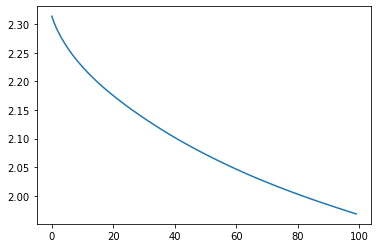



model의 output은 :  [0.03588076 0.7427788  0.09649274 0.01908892 0.04413509 0.0062709
 0.01000502 0.00878216 0.02517081 0.01139484]
argmax를 한 후의 output은 1
accuracy는 0.5370370370370371


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_6

0 2.3107247352600098
10 1.675586462020874
20 1.603448748588562
30 1.5234044790267944
40 1.498998761177063
50 1.4880248308181763


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.48114013671875
70 1.476347804069519
80 1.4733737707138062
90 1.4705556631088257


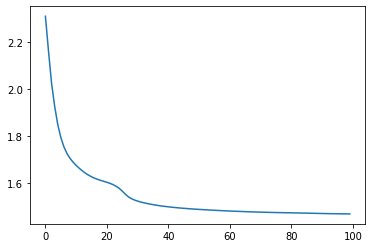



model의 output은 :  [9.5599817e-06 9.9970299e-01 5.8556012e-05 1.9615086e-08 1.2072399e-04
 3.2113001e-06 6.1770319e-05 1.4185104e-05 8.5777865e-06 2.0389338e-05]
argmax를 한 후의 output은 1
accuracy는 0.9740740740740741


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_6

0 2.313220262527466
10 1.6787902116775513
20 1.4947279691696167
30 1.4682986736297607
40 1.4664433002471924
50 1.4661166667938232


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4654079675674438
70 1.4653249979019165
80 1.4652754068374634
90 1.465240478515625


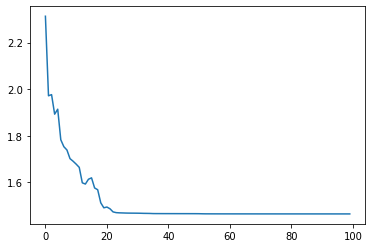



model의 output은 :  [5.3182036e-13 9.9999964e-01 2.7767075e-07 4.9417396e-14 2.0677249e-09
 3.1775168e-13 1.1804496e-07 3.4073556e-15 1.3364559e-08 2.7554505e-13]
argmax를 한 후의 output은 1
accuracy는 0.9740740740740741


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_6

0 2.294351577758789
10 1.6315162181854248
20 1.5349022150039673
30 1.5015747547149658
40 1.486128807067871
50 1.4770395755767822


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4726160764694214
70 1.4699429273605347
80 1.4681717157363892
90 1.4668673276901245


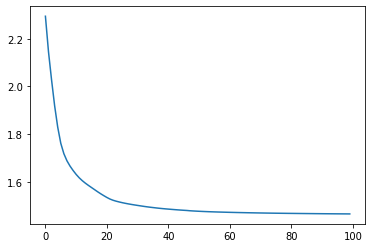



model의 output은 :  [2.2723696e-05 9.9811172e-01 6.0460869e-05 1.9024865e-04 2.7629323e-04
 2.5057214e-05 1.3038653e-03 3.6624449e-06 5.8174628e-06 1.2254621e-07]
argmax를 한 후의 output은 1
accuracy는 0.9703703703703703


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_6

0 2.28637957572937
10 1.5082701444625854
20 1.4684730768203735
30 1.4654815196990967
40 1.4641125202178955
50 1.463815450668335


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4636902809143066
70 1.4629460573196411
80 1.4628852605819702
90 1.4628475904464722


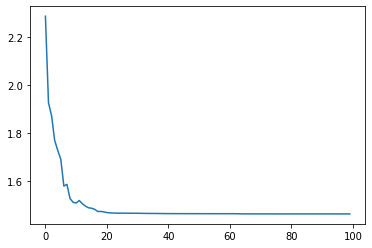



model의 output은 :  [1.2879857e-12 9.9999952e-01 1.2833115e-07 1.0160706e-08 1.3116352e-10
 3.7696719e-07 2.8833012e-09 5.2701553e-14 4.2103564e-11 1.8075177e-08]
argmax를 한 후의 output은 1
accuracy는 0.9703703703703703


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_6

0 2.320131778717041
10 2.3625032901763916
20 2.3625032901763916
30 2.3625032901763916
40 2.3625032901763916
50 2.3625032901763916


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 2.3625032901763916
70 2.3625032901763916
80 2.3625032901763916
90 2.3625032901763916


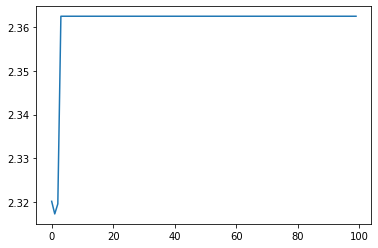



model의 output은 :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output은 2
accuracy는 0.09814814814814815


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_6

0 2.2910172939300537
10 2.122107982635498
20 1.9585204124450684
30 1.8165251016616821
40 1.714847445487976
50 1.6580809354782104


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.6157279014587402
70 1.5719501972198486
80 1.5371097326278687
90 1.5208659172058105


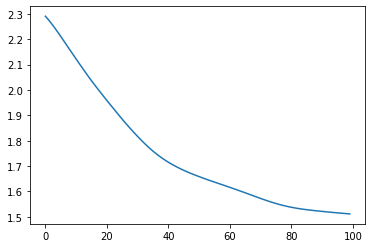



model의 output은 :  [2.3084003e-03 1.5809169e-01 8.1724770e-02 5.7719316e-02 6.2166890e-03
 3.3329832e-03 5.3327197e-01 1.8575009e-05 1.3326924e-01 2.4046401e-02]
argmax를 한 후의 output은 6
accuracy는 0.9444444444444444


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_6

0 2.3456156253814697
10 1.6147083044052124
20 1.4970710277557373
30 1.472733497619629
40 1.4668478965759277
50 1.4652392864227295


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


60 1.4632619619369507
70 1.462937355041504
80 1.4628725051879883
90 1.4628347158432007


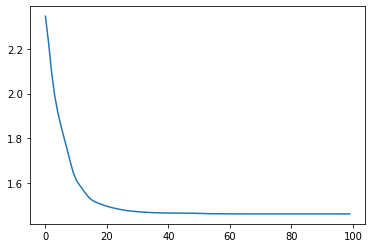



model의 output은 :  [1.5702334e-12 9.9999940e-01 5.1625301e-07 4.4996139e-11 9.1743377e-09
 1.3650643e-13 8.5647389e-10 4.3486035e-13 2.4562997e-08 1.1732456e-08]
argmax를 한 후의 output은 1
accuracy는 0.9703703703703703


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_6

0 2.320146322250366
10 1.4975309371948242
20 1.4764201641082764
30 1.4731711149215698


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4699736833572388
50 1.4698536396026611
60 1.4697890281677246
70 1.4697747230529785
80 1.46975839138031
90 1.469734787940979


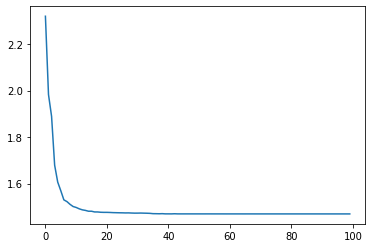



model의 output은 :  [0.0000000e+00 1.0000000e+00 4.2038954e-45 0.0000000e+00 0.0000000e+00
 1.9027038e-38 1.1490647e-43 1.4012985e-45 1.7675404e-35 1.7911412e-27]
argmax를 한 후의 output은 1
accuracy는 0.9666666666666667


In [34]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_6\n')
        model = Model()
        model.apply(init_weights_h)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            cost = loss_fn(model(x_train), y_train)
            cost.backward()
            optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_6', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

7. hidden layer 수: 3, sigmoid 활용


In [35]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 200, bias=True),
                                    nn.Sigmoid(),
                                    nn.BatchNorm1d(200))
        self.layer2 = nn.Sequential(nn.Linear(200, 80, bias=True),
                                    nn.Sigmoid())
        self.layer3 = nn.Sequential(nn.Linear(80, 30, bias=True),
                                    nn.Sigmoid())
        self.layer4 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        return output



최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_7

0 2.3046061992645264
10 2.3045976161956787
20 2.304588556289673


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


30 2.3045802116394043
40 2.3045713901519775
50 2.3045623302459717
60 2.304553747177124
70 2.3045451641082764
80 2.3045363426208496
90 2.304527759552002


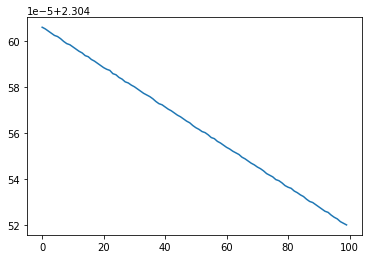



model의 output은 :  [0.07064515 0.1289549  0.17116736 0.0623021  0.10144021 0.06608562
 0.1176065  0.06852611 0.16487776 0.04839425]
argmax를 한 후의 output은 2
accuracy는 0.07962962962962963


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_7

0 2.3036320209503174
10 2.3035266399383545
20 2.3034207820892334
30 2.3033149242401123


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.303208589553833
50 2.3031017780303955
60 2.302995443344116
70 2.3028886318206787
80 2.302781343460083
90 2.3026740550994873


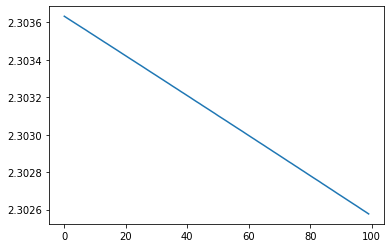



model의 output은 :  [0.12822215 0.04387361 0.06291985 0.12108582 0.02374202 0.10218723
 0.15346593 0.12930629 0.18348005 0.05171705]
argmax를 한 후의 output은 8
accuracy는 0.08888888888888889


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_7

0 2.30366849899292
10 2.302616596221924
20 2.3015575408935547
30 2.300490379333496


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.2994132041931152
50 2.2983238697052
60 2.2972211837768555
70 2.2961041927337646
80 2.2949700355529785
90 2.2938172817230225


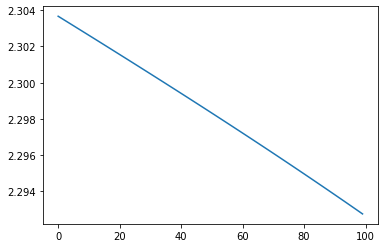



model의 output은 :  [0.05483968 0.17565368 0.04297983 0.15247028 0.10655441 0.18534644
 0.0462259  0.02444383 0.03774863 0.17373726]
argmax를 한 후의 output은 5
accuracy는 0.2074074074074074


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_7

0 2.307380199432373
10 2.2849605083465576
20 2.2691943645477295
30 2.254776954650879


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.2417051792144775
50 2.230006217956543
60 2.2195584774017334
70 2.2101893424987793
80 2.2017297744750977
90 2.194035768508911


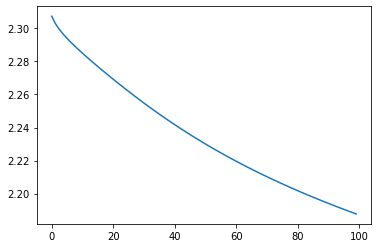



model의 output은 :  [0.02723585 0.02078659 0.21133636 0.10963895 0.09655152 0.03106756
 0.3081421  0.02453062 0.05424961 0.11646094]
argmax를 한 후의 output은 6
accuracy는 0.40185185185185185


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_7

0 2.3054466247558594
10 2.026996374130249
20 1.9098808765411377
30 1.845137357711792


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.7934378385543823
50 1.7510071992874146
60 1.7131953239440918
70 1.6765820980072021
80 1.642543911933899
90 1.6123422384262085


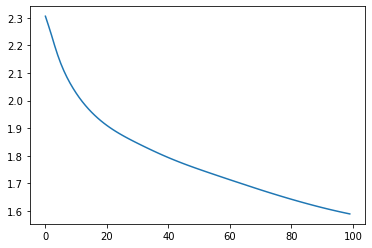



model의 output은 :  [0.00792909 0.91129786 0.0041372  0.00372445 0.00778934 0.00641913
 0.00748629 0.0164312  0.00655585 0.02822964]
argmax를 한 후의 output은 1
accuracy는 0.9851851851851852


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_7

0 2.303968906402588
10 1.8183674812316895
20 1.6867709159851074
30 1.6648170948028564


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.6577506065368652
50 1.5557420253753662
60 1.4949086904525757
70 1.4734565019607544
80 1.469464898109436
90 1.4679734706878662


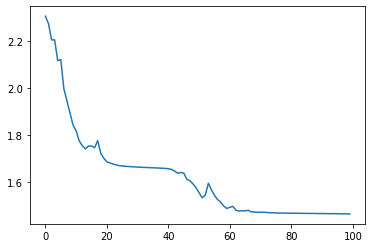



model의 output은 :  [1.0349615e-04 9.9070764e-01 1.2429326e-03 3.1379270e-03 7.3382241e-04
 7.3756126e-04 1.1494919e-04 8.1866112e-04 2.3864214e-03 1.6534641e-05]
argmax를 한 후의 output은 1
accuracy는 0.9833333333333333


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_7

0 2.3031489849090576
10 2.0115606784820557
20 1.8642199039459229
30 1.7933038473129272


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.751155972480774
50 1.7093803882598877
60 1.6743278503417969
70 1.6516449451446533
80 1.6359416246414185
90 1.6239742040634155


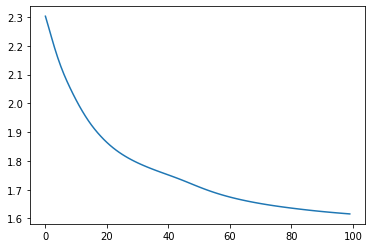



model의 output은 :  [0.01880295 0.00492335 0.17240424 0.03338812 0.07820565 0.2695614
 0.3280716  0.00489624 0.05410486 0.03564167]
argmax를 한 후의 output은 6
accuracy는 0.8888888888888888


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_7

0 2.3036580085754395
10 1.7264270782470703
20 1.5844024419784546
30 1.5668628215789795


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4946740865707397
50 1.4739587306976318
60 1.4686652421951294
70 1.4673864841461182
80 1.4666495323181152
90 1.4651036262512207


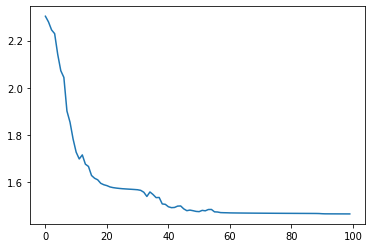



model의 output은 :  [2.76055471e-05 9.97615695e-01 3.01385124e-04 2.98505056e-05
 8.58047453e-04 1.07568189e-06 3.53882468e-04 1.08193424e-04
 2.13899606e-04 4.90346050e-04]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_7

0 2.301335096359253


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.3617076873779297
20 2.3617076873779297
30 2.3617076873779297
40 2.3617076873779297
50 2.3617076873779297
60 2.3617076873779297
70 2.3617076873779297
80 2.3617076873779297
90 2.3617076873779297


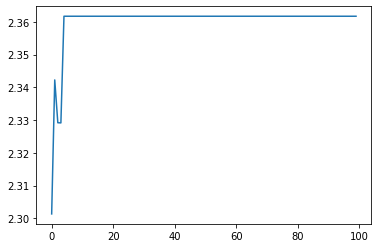



model의 output은 :  [2.5600020e-18 5.5979704e-11 1.2065197e-11 4.7486093e-14 4.6327622e-07
 1.1405165e-14 5.4605449e-09 9.9999952e-01 4.2971330e-19 2.8874704e-18]
argmax를 한 후의 output은 7
accuracy는 0.1


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_7

0 2.3025829792022705
10 2.262632369995117
20 2.2157180309295654
30 2.166844367980957


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.116178035736084
50 2.06404709815979
60 2.010559320449829
70 1.955594539642334
80 1.900262475013733
90 1.8470654487609863


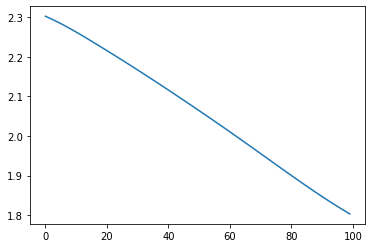



model의 output은 :  [0.02657127 0.64764595 0.04679976 0.02467658 0.0262481  0.00738925
 0.0676865  0.01455175 0.10594568 0.03248516]
argmax를 한 후의 output은 1
accuracy는 0.8685185185185185


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_7

0 2.301084041595459
10 1.9669243097305298
20 1.7033947706222534
30 1.5428123474121094


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4875251054763794
50 1.4740774631500244
60 1.4696708917617798
70 1.467078685760498
80 1.4659231901168823
90 1.4651788473129272


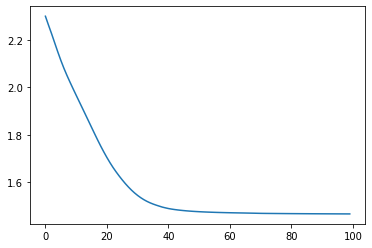



model의 output은 :  [4.7565711e-05 9.9606270e-01 6.8277834e-05 5.5636209e-04 1.4810727e-03
 4.4332398e-04 6.1758758e-05 1.0775963e-04 9.2092226e-04 2.5014946e-04]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_7

0 2.303349256515503
10 1.868056297302246


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


20 1.6903660297393799
30 1.597678542137146
40 1.5833394527435303
50 1.5895134210586548
60 1.588544487953186
70 1.577978491783142
80 1.585429072380066
90 1.6063134670257568


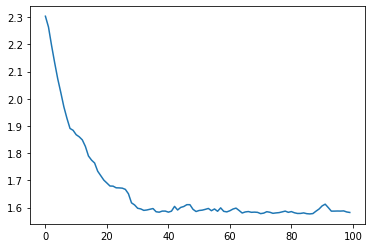



model의 output은 :  [1.3937774e-08 9.9833435e-01 1.1749635e-03 2.9960407e-08 6.0532631e-05
 3.5825581e-04 9.3199031e-07 5.5358858e-05 8.9583000e-07 1.4721372e-05]
argmax를 한 후의 output은 1
accuracy는 0.8462962962962963


In [36]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_7\n')
        model = Model()
        model.apply(init_weights_x)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            cost = loss_fn(model(x_train), y_train)
            cost.backward()
            optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_7', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

8. hidden layer 수: 3, tanh 활용


In [37]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 200, bias=True),
                                    nn.Tanh(),
                                    nn.BatchNorm1d(200))
        self.layer2 = nn.Sequential(nn.Linear(200, 80, bias=True),
                                    nn.Tanh())
        self.layer3 = nn.Sequential(nn.Linear(80, 30, bias=True),
                                    nn.Tanh())
        self.layer4 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        return output



최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_8

0 2.3111371994018555
10 2.3106281757354736
20 2.310114860534668
30 2.309596061706543


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.309072732925415
50 2.308544397354126
60 2.3080108165740967
70 2.3074722290039062
80 2.306928873062134
90 2.306380271911621


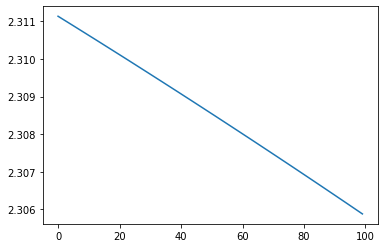



model의 output은 :  [0.09259845 0.0374226  0.07657823 0.08843915 0.11086695 0.185842
 0.07977375 0.10765816 0.17162076 0.04919994]
argmax를 한 후의 output은 5
accuracy는 0.09259259259259259


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_8

0 2.29166316986084
10 2.282259702682495
20 2.2715296745300293
30 2.259359836578369


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.2456414699554443
50 2.2303812503814697
60 2.213783025741577
70 2.1960971355438232
80 2.17751145362854
90 2.158249616622925


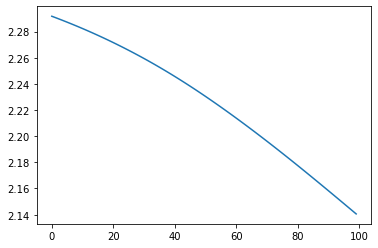



model의 output은 :  [0.02150239 0.15010318 0.2635706  0.14463432 0.03289067 0.0873668
 0.04368987 0.11194137 0.11218149 0.03211929]
argmax를 한 후의 output은 2
accuracy는 0.5722222222222222


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_8

0 2.30461049079895
10 2.2161359786987305
20 2.0685536861419678
30 1.9409565925598145


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.8471043109893799
50 1.7780126333236694
60 1.7249646186828613
70 1.6828356981277466
80 1.6493760347366333
90 1.6227679252624512


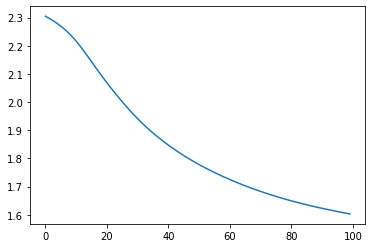



model의 output은 :  [0.01756665 0.8318715  0.00774481 0.02827342 0.00303347 0.03524649
 0.00108371 0.0277115  0.01945629 0.02801217]
argmax를 한 후의 output은 1
accuracy는 0.9462962962962963


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_8

0 2.3169448375701904
10 2.0782053470611572
20 1.9592574834823608
30 1.8831751346588135


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.8288904428482056
50 1.7874245643615723
60 1.754477858543396
70 1.7276394367218018
80 1.7055081129074097
90 1.6866960525512695


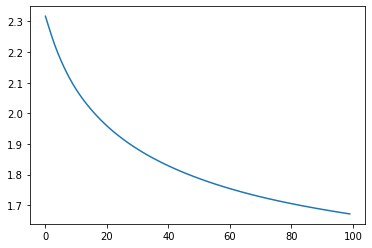



model의 output은 :  [0.00599405 0.8288963  0.02350762 0.01350457 0.03401524 0.03591749
 0.02931489 0.00402094 0.01595686 0.00887204]
argmax를 한 후의 output은 1
accuracy는 0.9166666666666666


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_8

0 2.3039093017578125
10 1.5401601791381836
20 1.4987434148788452
30 1.4860312938690186


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.479494571685791
50 1.475623369216919
60 1.4732375144958496
70 1.4715919494628906
80 1.4703725576400757
90 1.469426155090332


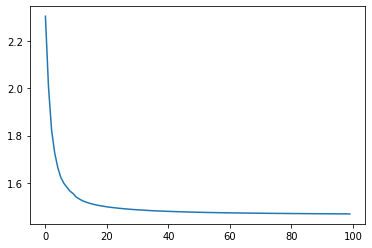



model의 output은 :  [4.6041826e-04 9.9622881e-01 8.6117187e-04 2.1876593e-04 2.1165681e-04
 5.1063340e-04 3.7010448e-04 1.1633195e-04 8.6606777e-04 1.5592402e-04]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_8

0 2.3131003379821777
10 1.724030613899231
20 1.5392709970474243
30 1.4920064210891724


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.48848557472229
50 1.485506534576416
60 1.4674376249313354
70 1.4669941663742065
80 1.4667631387710571
90 1.4666225910186768


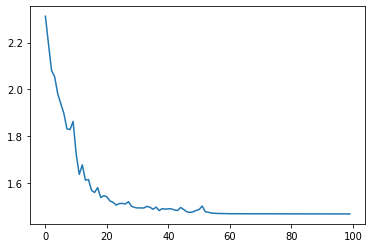



model의 output은 :  [1.4460545e-07 9.9990392e-01 1.3663043e-05 8.2827173e-06 1.3522615e-05
 8.0438858e-06 2.4330751e-05 4.5096344e-06 1.6131105e-05 7.5277535e-06]
argmax를 한 후의 output은 1
accuracy는 0.9537037037037037


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_8

0 2.309290885925293
10 1.5235075950622559
20 1.488322377204895
30 1.478272557258606


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4736251831054688
50 1.4708974361419678
60 1.4692039489746094
70 1.4677674770355225
80 1.4666597843170166
90 1.4659028053283691


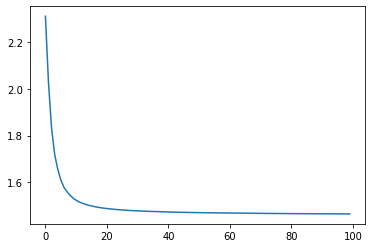



model의 output은 :  [7.8605383e-04 9.9536914e-01 3.0252550e-04 3.0623024e-04 4.2756574e-04
 3.1468234e-04 7.4054245e-05 7.7989657e-04 9.9188369e-04 6.4804591e-04]
argmax를 한 후의 output은 1
accuracy는 0.9833333333333333


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_8

0 2.2859694957733154
10 1.665023684501648
20 1.5526585578918457
30 1.5173734426498413


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4822330474853516
50 1.4813838005065918
60 1.4697965383529663
70 1.4652258157730103
80 1.4644837379455566
90 1.4640127420425415


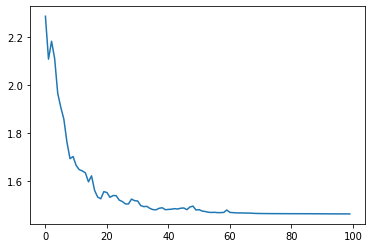



model의 output은 :  [1.4151432e-07 9.9986410e-01 1.1872020e-05 2.2630848e-06 4.4395700e-05
 6.2962800e-07 3.9513757e-06 3.0718263e-07 6.8695008e-05 3.5412133e-06]
argmax를 한 후의 output은 1
accuracy는 0.9648148148148148


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_8

0 2.309617280960083
10 2.360912561416626
20 2.360912561416626
30 2.360912322998047


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.360912322998047
50 2.360912322998047
60 2.360912322998047
70 2.360912322998047
80 2.360912322998047
90 2.360912322998047


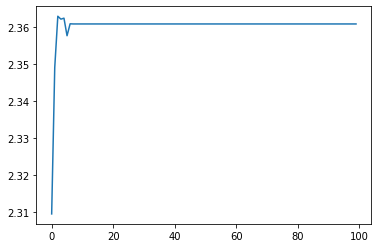



model의 output은 :  [7.1888090e-17 7.1947788e-20 2.3366814e-23 1.1592913e-21 7.2436167e-17
 1.7657698e-18 1.3740743e-21 4.1234212e-15 9.8444011e-16 1.0000000e+00]
argmax를 한 후의 output은 9
accuracy는 0.1


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_8

0 2.3155100345611572
10 1.9461630582809448
20 1.7185417413711548


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


30 1.6135272979736328
40 1.5554428100585938
50 1.5219424962997437
60 1.502712607383728
70 1.491864800453186
80 1.4853706359863281
90 1.4813417196273804


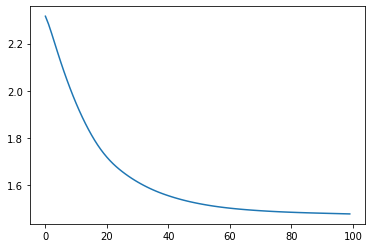



model의 output은 :  [8.0448139e-04 9.8432654e-01 2.8897377e-03 1.9662953e-03 7.1524555e-04
 1.0845443e-03 5.1135216e-03 2.1845693e-04 1.9365686e-03 9.4453938e-04]
argmax를 한 후의 output은 1
accuracy는 0.9777777777777777


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_8

0 2.3008716106414795
10 1.4910176992416382
20 1.466508388519287
30 1.4630876779556274


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4619053602218628
50 1.461672067642212
60 1.4615750312805176
70 1.4615176916122437
80 1.4614779949188232
90 1.4614473581314087


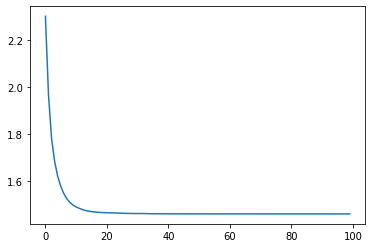



model의 output은 :  [4.99997213e-07 9.99626160e-01 1.06713494e-04 3.18354832e-05
 1.68463903e-05 1.63544828e-05 1.92672032e-05 1.35281189e-05
 7.32497938e-05 9.55784781e-05]
argmax를 한 후의 output은 1
accuracy는 0.9796296296296296


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_8

0 2.2959420680999756
10 1.6865323781967163
20 1.5906809568405151


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


30 1.5693084001541138
40 1.543474555015564
50 1.5680274963378906
60 1.6030291318893433
70 1.5822242498397827
80 1.5906193256378174
90 1.5887272357940674


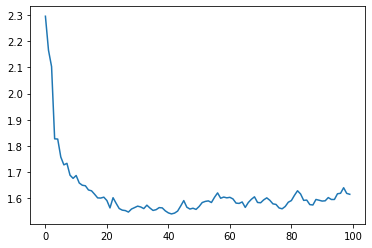



model의 output은 :  [1.0313556e-13 2.8241948e-05 3.9937167e-04 7.1074697e-07 5.4130832e-11
 9.9957162e-01 5.8007569e-08 1.6403944e-11 6.6371486e-10 5.4283693e-13]
argmax를 한 후의 output은 5
accuracy는 0.8148148148148148


In [38]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_8\n')
        model = Model()
        model.apply(init_weights_x)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            cost = loss_fn(model(x_train), y_train)
            cost.backward()
            optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_8', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

9. hidden layer 수: 3, ReLU 활용


In [39]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 200, bias=True),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(200))
        self.layer2 = nn.Sequential(nn.Linear(200, 80, bias=True),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(80, 30, bias=True),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        return output



최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_9

0 2.3084607124328613
10 2.3077621459960938
20 2.3070571422576904
30 2.306344509124756


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.3056278228759766
50 2.304910659790039
60 2.304189682006836
70 2.3034658432006836
80 2.3027358055114746
90 2.3019988536834717


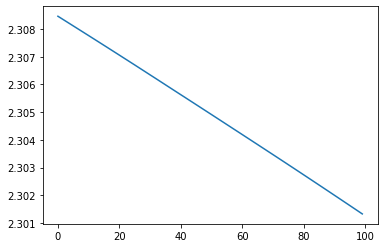



model의 output은 :  [0.05322655 0.04073148 0.00946676 0.02694518 0.11405297 0.21309672
 0.02435305 0.2781649  0.07389005 0.16607235]
argmax를 한 후의 output은 7
accuracy는 0.10555555555555556


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_9

0 2.3137197494506836
10 2.3094844818115234
20 2.3050336837768555
30 2.3003060817718506


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.295290231704712
50 2.289872884750366
60 2.284014940261841
70 2.2776336669921875
80 2.2704551219940186
90 2.2624258995056152


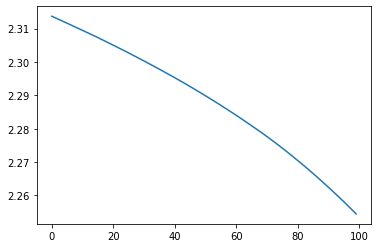



model의 output은 :  [0.15194622 0.06185368 0.00552143 0.17670225 0.01084545 0.10677353
 0.0125978  0.14373131 0.05593916 0.2740892 ]
argmax를 한 후의 output은 9
accuracy는 0.1925925925925926


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_9

0 2.3025896549224854
10 2.2030019760131836
20 2.1165854930877686
30 2.045027017593384


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.9535622596740723
50 1.871458888053894
60 1.811699390411377
70 1.7605353593826294
80 1.727931261062622
90 1.7011582851409912


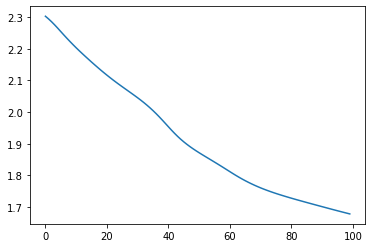



model의 output은 :  [5.04932832e-04 8.52767751e-03 1.16744585e-01 4.39263927e-03
 8.54195002e-03 7.44596064e-01 1.09722286e-01 6.02622284e-04
 2.75356090e-03 3.61364125e-03]
argmax를 한 후의 output은 5
accuracy는 0.8018518518518518


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_9

0 2.3144783973693848
10 2.1486284732818604
20 2.0303146839141846
30 1.945480465888977


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.872087836265564
50 1.8123098611831665
60 1.768489956855774
70 1.7370003461837769
80 1.7130109071731567
90 1.6947143077850342


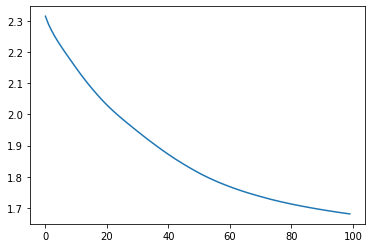



model의 output은 :  [5.1316636e-04 5.9389704e-01 2.3846300e-01 8.0928534e-02 2.6849624e-02
 4.6349178e-05 4.8588783e-02 1.7264106e-03 2.2813180e-03 6.7057232e-03]
argmax를 한 후의 output은 1
accuracy는 0.8296296296296296


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_9

0 2.2889347076416016
10 1.483789324760437
20 1.4714049100875854
30 1.4668523073196411


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4647274017333984
50 1.464145302772522
60 1.4638170003890991
70 1.4636048078536987
80 1.4634555578231812
90 1.4633456468582153


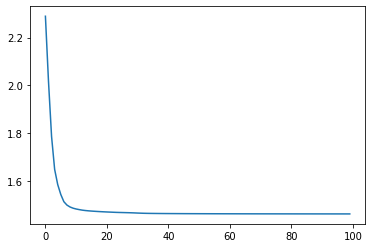



model의 output은 :  [6.4770637e-07 9.9744546e-01 2.5709407e-04 7.0111710e-06 3.2929057e-04
 2.1815732e-04 1.1018897e-04 2.1993252e-04 1.3092960e-03 1.0285219e-04]
argmax를 한 후의 output은 1
accuracy는 0.975925925925926


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_9

0 2.2901461124420166
10 2.0261929035186768
20 1.965566635131836


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


30 1.9617189168930054
40 1.862850308418274
50 1.8048791885375977
60 1.7318919897079468
70 1.6653636693954468
80 1.664268970489502
90 1.6641477346420288


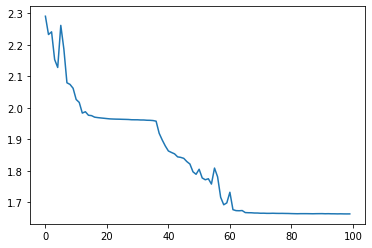



model의 output은 :  [2.3127970e-14 1.0000000e+00 5.3214879e-15 5.0600130e-10 2.0171951e-11
 3.3195593e-13 1.4913418e-17 1.4702776e-17 3.9432027e-09 2.6684926e-08]
argmax를 한 후의 output은 1
accuracy는 0.7851851851851852


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_9

0 2.305476665496826
10 1.4874260425567627
20 1.4723907709121704
30 1.467796802520752


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4653407335281372
50 1.464629054069519
60 1.4643138647079468
70 1.4641231298446655
80 1.4639955759048462
90 1.463903784751892


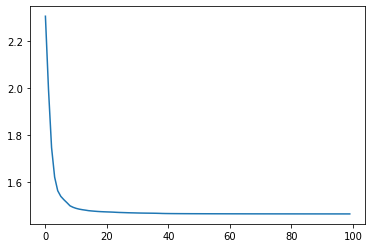



model의 output은 :  [3.3190813e-07 9.9996829e-01 1.8568389e-05 5.4212174e-10 2.3025117e-07
 3.3770302e-06 9.1741622e-06 5.3490545e-09 6.9845911e-09 1.2227935e-08]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_9

0 2.312330722808838
10 1.816985011100769


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


20 1.7711384296417236
30 1.7700053453445435
40 1.7662290334701538
50 1.765415072441101
60 1.7662451267242432
70 1.6783779859542847
80 1.668097734451294
90 1.667035698890686


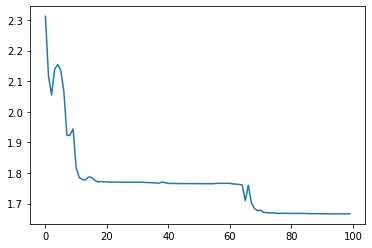



model의 output은 :  [2.4175344e-29 8.8136090e-36 1.0000000e+00 6.4628623e-25 6.8875679e-15
 6.3948432e-22 7.1318353e-16 5.5146877e-33 2.5341903e-23 7.5132427e-36]
argmax를 한 후의 output은 2
accuracy는 0.7851851851851852


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_9

0 2.32084584236145
10 2.360912322998047
20 2.360912322998047
30 2.360912322998047


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 2.360912322998047
50 2.360912322998047
60 2.360912322998047
70 2.360912322998047
80 2.360912322998047
90 2.360912322998047


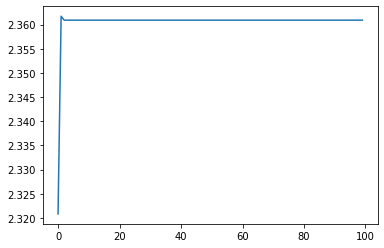



model의 output은 :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
argmax를 한 후의 output은 9
accuracy는 0.1


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_9

0 2.3222808837890625
10 2.0617804527282715
20 1.796034812927246
30 1.632503867149353


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.542641043663025
50 1.4981987476348877
60 1.4844592809677124
70 1.4769450426101685
80 1.4727165699005127
90 1.4700855016708374


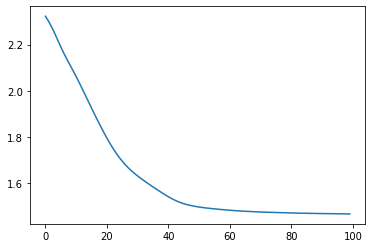



model의 output은 :  [7.4166911e-07 9.9752551e-01 4.2575348e-06 4.8453501e-05 1.4360735e-06
 4.3760092e-04 3.0925778e-05 1.3295759e-09 1.9498823e-03 1.2106199e-06]
argmax를 한 후의 output은 1
accuracy는 0.9740740740740741


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_9

0 2.3003952503204346
10 1.497291088104248
20 1.4737443923950195
30 1.470098853111267


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4659183025360107
50 1.4651495218276978
60 1.4650981426239014
70 1.4650706052780151
80 1.4650468826293945
90 1.4650477170944214


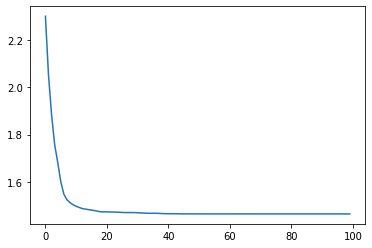



model의 output은 :  [6.6529878e-21 1.0000000e+00 5.0671695e-10 2.1456199e-21 2.9747677e-19
 5.7242619e-21 5.9758309e-12 4.7955833e-23 2.3456302e-08 1.1821097e-16]
argmax를 한 후의 output은 1
accuracy는 0.9777777777777777


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_9

0 2.2963361740112305
10 2.0154049396514893


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


20 1.9917658567428589
30 1.9901646375656128
40 2.0013139247894287
50 2.005979299545288
60 2.045083522796631
70 2.0378258228302
80 2.1317267417907715
90 2.1333863735198975


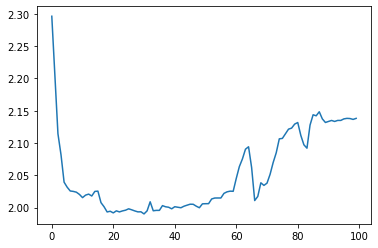



model의 output은 :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output은 1
accuracy는 0.3074074074074074


In [40]:
for opt in opts:
    for lr in lrs:
        print('\n=====================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_9\n')
        model = Model()
        model.apply(init_weights_h)
        optimizer = SetOptimizer(opt, lr)
        loss_fn = nn.CrossEntropyLoss()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            cost = loss_fn(model(x_train), y_train)
            cost.backward()
            optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item()) 
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_9', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

In [41]:
result.sort_values('accuracy', ascending=False).head(10)

,loss,learning_rate,optimizer,accuracy,epoch,model
76,1.589448,0.010,Adagrad,0.985185,99,model_7
77,1.466393,0.100,Adagrad,0.983333,99,model_7
90,1.465377,0.001,RMSprop,0.983333,99,model_8
82,1.464699,0.010,Adam,0.981481,99,model_7
94,1.461424,0.010,Adam,0.979630,99,model_8
93,1.478393,0.001,Adam,0.977778,99,model_8
41,1.464958,0.100,Adagrad,0.977778,99,model_4
106,1.465044,0.010,Adam,0.977778,99,model_9
100,1.463268,0.010,Adagrad,0.975926,99,model_9
40,1.533640,0.010,Adagrad,0.975926,99,model_4


## 결과 분석:
### 1. adagrad optimizer를 활용하고 lr을 0.01로 설정하였을 때, acc가 0.985185로 가장 높은 성능을 보였다.
### 2. 해당 모델은 hidden layer가 3개인 가장 복잡한 모델이며, sigmoid 함수를 활성함수로 사용했고 xavier 초기화를 사용했다.

**위에서 점수가 높았던 model_4, 7, 8, 9에 대해 미니 배치 경사 하강 알고리즘 적용하여 결과 비교하기.**

1. model_4

In [42]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 100, bias=True),
                                    nn.Sigmoid(),
                                    nn.BatchNorm1d(100))
        self.layer2 = nn.Sequential(nn.Linear(100, 30, bias=True),
                                    nn.Sigmoid())
        self.layer3 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        return output

<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_4_mini

0 2.313687562942505
10 2.3125319480895996
20 2.3113484382629395
30 2.3101370334625244
40 2.3088972568511963
50 2.307629108428955
60 2.30633282661438
70 2.3050074577331543
80 2.303654193878174
90 2.302272081375122


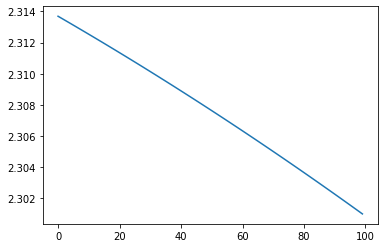



model의 output은 :  [0.10345183 0.12023716 0.04322623 0.07529502 0.15775786 0.20907286
 0.05863374 0.07045491 0.10647973 0.05539063]
argmax를 한 후의 output은 5
accuracy는 0.1425925925925926


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_4_mini

0 2.3043055534362793


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.2805094718933105
20 2.248586654663086
30 2.2147128582000732
40 2.1834115982055664
50 2.1555867195129395
60 2.131002187728882
70 2.1081929206848145
80 2.0850110054016113
90 2.059797525405884


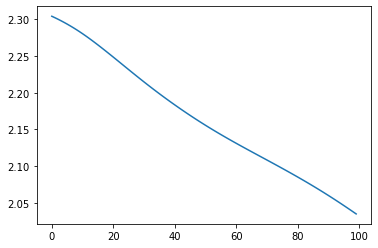



model의 output은 :  [0.0741834  0.105795   0.06232851 0.13078569 0.1604754  0.1111849
 0.13772394 0.13398446 0.04690053 0.0366381 ]
argmax를 한 후의 output은 4
accuracy는 0.5296296296296297


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_4_mini

0 2.272526264190674


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.921525001525879
20 1.786967396736145
30 1.728050947189331
40 1.7011882066726685
50 1.6898239850997925
60 1.6827073097229004
70 1.6721792221069336
80 1.609586238861084
90 1.5760301351547241


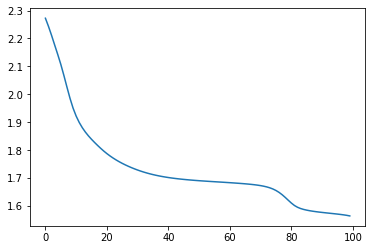



model의 output은 :  [0.00109299 0.95053834 0.01791262 0.00187783 0.00183771 0.00460389
 0.00596161 0.00129179 0.00811959 0.00676363]
argmax를 한 후의 output은 1
accuracy는 0.8925925925925926


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_4_mini

0 2.2683587074279785


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.1057069301605225
20 2.039628744125366
30 2.0004615783691406
40 1.9734437465667725
50 1.9543308019638062
60 1.940070390701294
70 1.9287407398223877
80 1.9192132949829102
90 1.9107915163040161


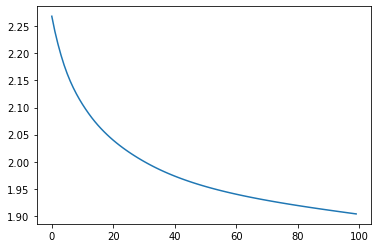



model의 output은 :  [0.02615103 0.63760453 0.02744915 0.06604923 0.04092136 0.02066714
 0.10422364 0.05547252 0.00878376 0.01267775]
argmax를 한 후의 output은 1
accuracy는 0.5888888888888889


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_4_mini

0 1.9967482089996338


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.5480141639709473
20 1.4964730739593506
30 1.4835649728775024
40 1.4776207208633423
50 1.4739067554473877
60 1.4714319705963135
70 1.4697521924972534
80 1.468569278717041
90 1.467689871788025


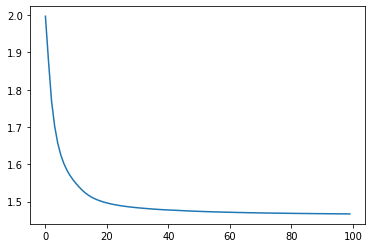



model의 output은 :  [1.0379758e-03 9.9186134e-01 1.4485437e-03 1.1361561e-03 1.7881158e-03
 5.2607898e-04 4.6326529e-04 2.7180588e-04 8.5436739e-04 6.1238237e-04]
argmax를 한 후의 output은 1
accuracy는 0.9777777777777777


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_4_mini

0 1.7075433731079102


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4809496402740479
20 1.4621127843856812
30 1.4617962837219238
40 1.4616475105285645
50 1.461550235748291
60 1.4614872932434082
70 1.461442470550537
80 1.4614087343215942
90 1.4613819122314453


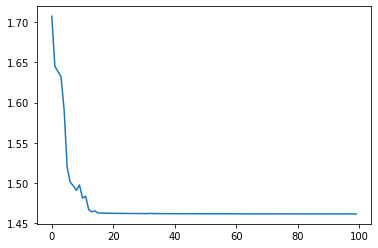



model의 output은 :  [6.2699264e-06 9.9925822e-01 2.0435161e-04 2.8887465e-05 2.0937201e-05
 7.9436402e-05 5.3538690e-05 7.2897302e-07 3.2795861e-04 1.9565316e-05]
argmax를 한 후의 output은 1
accuracy는 0.9740740740740741


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_4_mini

0 1.930105209350586


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.5406352281570435
20 1.4772707223892212
30 1.467071294784546
40 1.4635075330734253
50 1.4621617794036865
60 1.4615806341171265
70 1.461331844329834
80 1.4612271785736084
90 1.461182951927185


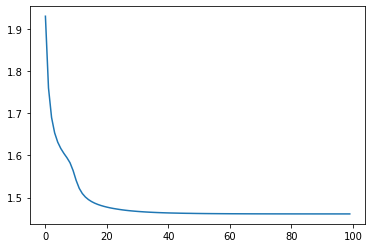



model의 output은 :  [4.72608207e-07 9.99980450e-01 2.19056187e-06 5.79601647e-08
 5.64778520e-06 4.84739019e-07 1.04583016e-07 2.23274967e-07
 6.94563550e-06 3.42431053e-06]
argmax를 한 후의 output은 1
accuracy는 0.9888888888888889


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_4_mini

0 1.7209064960479736


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4880610704421997
20 1.4784934520721436
30 1.510499119758606
40 1.4621402025222778
50 1.4613178968429565
60 1.4612051248550415
70 1.461682915687561
80 1.4644110202789307
90 1.4772560596466064


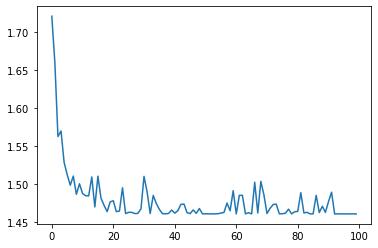



model의 output은 :  [4.6230914e-10 9.9998653e-01 1.7903694e-06 3.9087640e-09 9.3820223e-09
 1.8506496e-09 5.8689142e-07 1.2689785e-08 1.1030615e-05 6.8967374e-09]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_4_mini

0 2.290418863296509


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.290418863296509
20 2.2904183864593506
30 2.3635895252227783
40 2.36358904838562
50 2.290418863296509
60 2.290418863296509
70 2.290418863296509
80 2.290418863296509
90 2.290418863296509


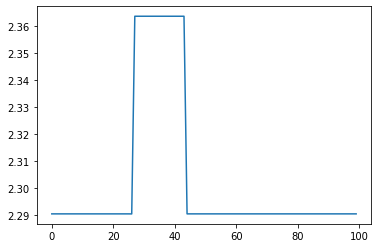



model의 output은 :  [1.0000000e+00 2.9761176e-12 5.0051012e-09 5.6169033e-15 1.1520630e-18
 3.3875226e-18 8.2139498e-17 6.1877153e-17 3.0431702e-15 1.7854353e-15]
argmax를 한 후의 output은 0
accuracy는 0.1


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_4_mini

0 2.200514793395996


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.6349234580993652
20 1.5785897970199585
30 1.4823849201202393
40 1.4712083339691162
50 1.4672248363494873
60 1.4654227495193481
70 1.4643526077270508
80 1.4636499881744385
90 1.4631574153900146


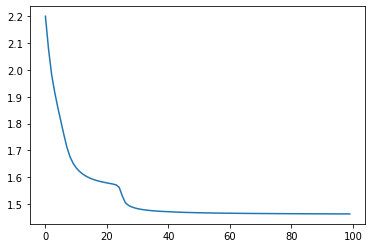



model의 output은 :  [1.2045369e-04 9.9768245e-01 7.2296371e-04 1.0667311e-04 9.4469295e-05
 1.4242620e-04 2.6940479e-04 9.5712945e-05 5.9480581e-04 1.7058285e-04]
argmax를 한 후의 output은 1
accuracy는 0.9777777777777777


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_4_mini

0 1.761473298072815


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.481316089630127
20 1.4626725912094116
30 1.4833463430404663
40 1.462075114250183
50 1.4618847370147705
60 1.4613044261932373
70 1.461242914199829
80 1.4612157344818115
90 1.461201548576355


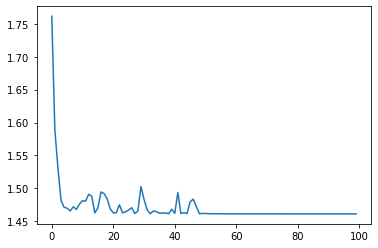



model의 output은 :  [1.7072892e-07 9.9997735e-01 6.4878504e-06 2.1691645e-07 5.7451330e-06
 3.0725157e-06 5.8735891e-06 4.9323599e-08 9.5564837e-07 1.4122065e-07]
argmax를 한 후의 output은 1
accuracy는 0.9648148148148148


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_4_mini

0 1.9315062761306763


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.9747135639190674
20 2.118931770324707
30 2.1311488151550293
40 2.1454803943634033
50 2.1929147243499756
60 2.1928579807281494
70 2.1928577423095703
80 2.1928579807281494
90 2.1928577423095703


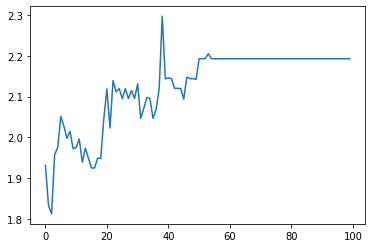



model의 output은 :  [5.3193271e-05 2.6219413e-07 2.9495968e-08 2.9586797e-08 1.6797131e-08
 4.3419428e-09 9.5647312e-09 1.0689983e-09 9.9994648e-01 1.1982728e-08]
argmax를 한 후의 output은 8
accuracy는 0.1962962962962963


In [43]:
for opt in opts:
    for lr in lrs:
        model = Model()
        model.apply(init_weights_x)
        criterion = nn.CrossEntropyLoss()
        optimizer = SetOptimizer(opt, lr)
        print('\n==========================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_4_mini\n')
        
        losses = []

        # 모델 학습
        for epoch in range(100):
            for x, y in dataloader:
                optimizer.zero_grad()
                y = y.squeeze(dim=-1)
                cost = criterion(model(x), y)
                cost.backward() # 역전파 연산
                optimizer.step() # 기울기 업데이트
            losses.append(cost.item()) # 1 epoch 당 손실점수 저장

            if epoch % 10 == 0:
                print(epoch, cost.item()) # 손실점수 산출
        
        plt.plot(losses)
        plt.show()
        print('\n')

        # 모델 평가(검증)
        with torch.no_grad(): # 모델 평가 연산에서는 grad 값 불필요
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy() # 계산 정보 기억 X, 넘파이 연산 가능하도록 변환
            predicted = np.argmax(y_pred, axis =1) # 행 방향으로 최댓값의 인덱스 값 저장
            accuracy = (accuracy_score(predicted, y_test))
        
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')

        row = {'epoch': epoch, 'model': 'model_4_mini', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True) # 반복문 실행하여 평가 점수 데이터프레임에 저장

2. model_7

In [44]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 200, bias=True),
                                    nn.Sigmoid(),
                                    nn.BatchNorm1d(200))
        self.layer2 = nn.Sequential(nn.Linear(200, 80, bias=True),
                                    nn.Sigmoid())
        self.layer3 = nn.Sequential(nn.Linear(80, 30, bias=True),
                                    nn.Sigmoid())
        self.layer4 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        return output

<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_7_mini

0 2.311760187149048
10 2.311448335647583
20 2.3111371994018555
30 2.3108270168304443
40 2.3105170726776123
50 2.3102073669433594
60 2.309898614883423
70 2.3095896244049072
80 2.30928111076355
90 2.3089728355407715


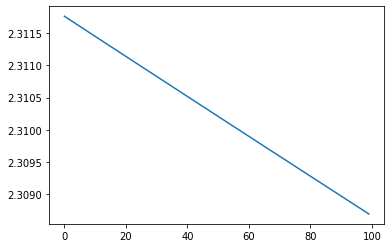



model의 output은 :  [0.15281714 0.2502253  0.03513891 0.21217138 0.05458698 0.0563524
 0.04339961 0.06213512 0.01236957 0.12080364]
argmax를 한 후의 output은 1
accuracy는 0.14814814814814814


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_7_mini

0 2.303049325942993


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.301392078399658
20 2.2997000217437744
30 2.2979655265808105
40 2.296182155609131
50 2.2943429946899414
60 2.2924435138702393
70 2.2904744148254395
80 2.2884249687194824
90 2.286278009414673


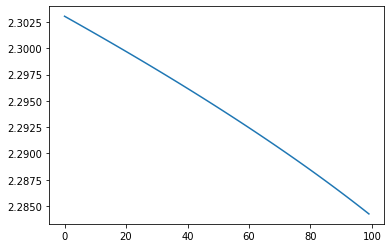



model의 output은 :  [0.08883727 0.04226678 0.09689726 0.13046435 0.13322371 0.20108849
 0.03236621 0.07132395 0.09097619 0.11255579]
argmax를 한 후의 output은 5
accuracy는 0.19444444444444445


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_7_mini

0 2.2811760902404785


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.224841594696045
20 2.135800361633301
30 2.054898500442505
40 1.9678115844726562
50 1.8642935752868652
60 1.7891631126403809
70 1.7536308765411377
80 1.7289499044418335
90 1.6824499368667603


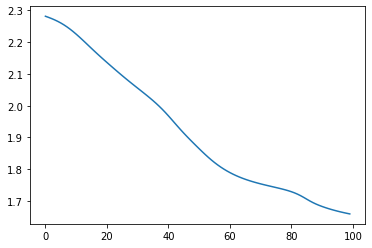



model의 output은 :  [0.00426953 0.90632707 0.05294035 0.00518109 0.00905327 0.00139014
 0.01245173 0.00220921 0.00207931 0.00409824]
argmax를 한 후의 output은 1
accuracy는 0.7888888888888889


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_7_mini

0 2.2683205604553223


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.1635913848876953
20 2.1105434894561768
30 2.0719597339630127
40 2.0400679111480713
50 2.012044668197632
60 1.9867388010025024
70 1.9636621475219727
80 1.94257652759552
90 1.9233770370483398


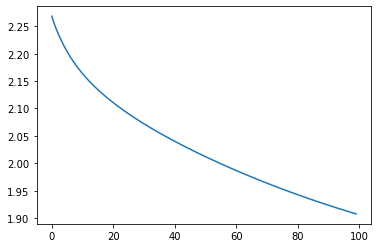



model의 output은 :  [0.03936175 0.36892253 0.03028798 0.07279123 0.00579492 0.11439273
 0.08358978 0.04576499 0.1175328  0.12156128]
argmax를 한 후의 output은 1
accuracy는 0.75


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_7_mini

0 1.9934664964675903


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.6144776344299316
20 1.582822322845459
30 1.5075733661651611
40 1.4850850105285645
50 1.477972149848938
60 1.4742937088012695
70 1.4720271825790405
80 1.4704413414001465
90 1.4692567586898804


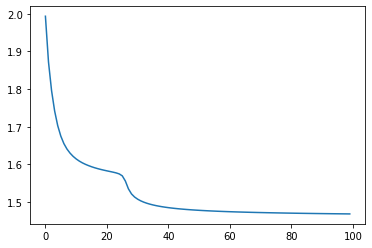



model의 output은 :  [1.7223005e-04 9.9128062e-01 9.1962000e-05 1.3804630e-03 5.2226178e-04
 1.0357868e-03 8.1743690e-04 3.3845272e-04 3.0788786e-03 1.2820278e-03]
argmax를 한 후의 output은 1
accuracy는 0.9740740740740741


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_7_mini

0 2.0320487022399902


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.5148866176605225
20 1.4628413915634155
30 1.4624148607254028
40 1.4620193243026733
50 1.4618163108825684
60 1.461706519126892
70 1.4648511409759521
80 1.4615905284881592
90 1.4615252017974854


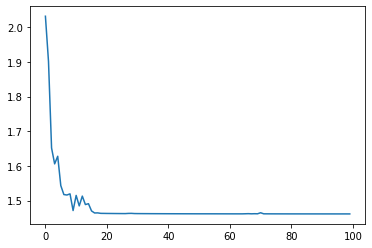



model의 output은 :  [6.0012368e-08 9.9973911e-01 3.1145428e-05 3.1948610e-05 2.3516373e-05
 9.0905206e-07 4.2403088e-05 1.4407881e-05 1.1649074e-04 3.1082845e-09]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_7_mini

0 2.075411319732666


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.6034077405929565
20 1.5158320665359497
30 1.4703845977783203
40 1.4645649194717407
50 1.4625319242477417
60 1.4617233276367188
70 1.4613897800445557
80 1.4612503051757812
90 1.461192011833191


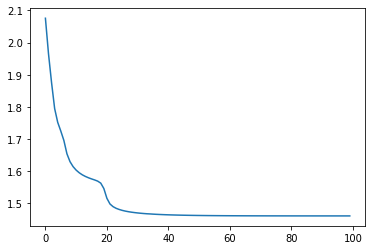



model의 output은 :  [9.1727998e-07 9.9998713e-01 2.7947981e-06 1.1545155e-08 2.6412283e-06
 4.5302937e-07 9.8302382e-07 1.0489892e-06 1.3623121e-08 3.9456554e-06]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_7_mini

0 2.0652616024017334


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4845495223999023
20 1.4648518562316895
30 1.485468864440918
40 1.4854331016540527
50 1.4941213130950928
60 1.4612222909927368
70 1.4761191606521606
80 1.4800934791564941
90 1.4821357727050781


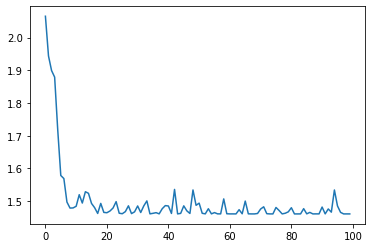



model의 output은 :  [8.3354312e-10 9.9998736e-01 6.9078482e-07 2.4852854e-08 4.0173891e-06
 1.0148487e-06 4.1956455e-06 4.0444998e-09 2.0266152e-06 6.0282071e-07]
argmax를 한 후의 output은 1
accuracy는 0.9629629629629629


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_7_mini

0 2.3635895252227783


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.3635895252227783
20 2.3635895252227783
30 2.3635895252227783
40 2.3635895252227783
50 2.3635895252227783
60 2.3635895252227783
70 2.3635895252227783
80 2.3635895252227783
90 2.3635895252227783


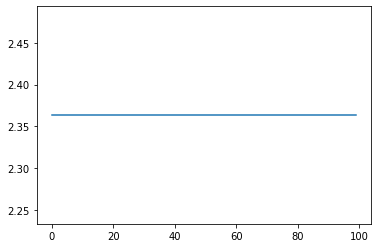



model의 output은 :  [2.2288955e-11 9.7465959e-12 1.0000000e+00 5.4905438e-12 5.5245543e-21
 2.7150000e-20 1.1651858e-17 9.9935293e-21 5.1341737e-20 1.0507766e-16]
argmax를 한 후의 output은 2
accuracy는 0.09814814814814815


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_7_mini

0 2.2294890880584717


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.6607599258422852
20 1.5158010721206665
30 1.4777352809906006
40 1.4705575704574585
50 1.4673819541931152
60 1.4656391143798828
70 1.4645209312438965
80 1.4637796878814697
90 1.4632556438446045


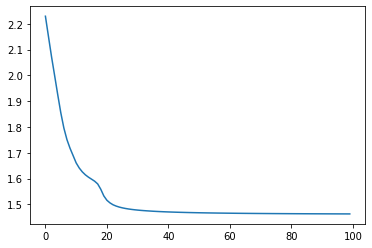



model의 output은 :  [2.6346866e-06 9.9800032e-01 2.8398051e-04 3.3635049e-04 3.5787612e-04
 5.2829640e-04 1.0803002e-04 8.3955609e-05 2.8606973e-04 1.2313853e-05]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_7_mini

0 1.9036383628845215


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.5139764547348022
20 1.4860759973526
30 1.5041838884353638
40 1.4624978303909302
50 1.5077533721923828
60 1.487046718597412
70 1.4614778757095337
80 1.485795497894287
90 1.4779436588287354


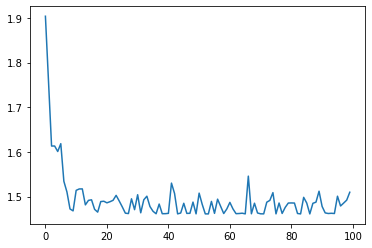



model의 output은 :  [1.0092100e-07 5.8333874e-01 4.1133603e-01 3.8457110e-03 1.2485931e-07
 1.9434416e-05 4.7317555e-04 7.8932339e-07 9.8589191e-04 6.3481068e-08]
argmax를 한 후의 output은 1
accuracy는 0.9277777777777778


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_7_mini

0 2.056205987930298


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.059925079345703
20 2.306495428085327
30 2.3635895252227783
40 2.3635895252227783
50 2.3635895252227783
60 2.3635895252227783
70 2.3635895252227783
80 2.3635895252227783
90 2.3635895252227783


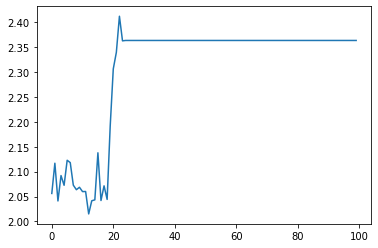



model의 output은 :  [1.4430949e-09 9.8665609e-09 1.0000000e+00 3.1605816e-09 3.0643193e-11
 1.2466829e-10 6.8040512e-12 1.8433531e-10 1.7306242e-09 1.6818723e-10]
argmax를 한 후의 output은 2
accuracy는 0.09814814814814815


In [45]:
for opt in opts:
    for lr in lrs:
        model = Model()
        model.apply(init_weights_x)
        criterion = nn.CrossEntropyLoss()
        optimizer = SetOptimizer(opt, lr)
        print('\n==========================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_7_mini\n')
        losses = []
        for epoch in range(100):
            for x, y in dataloader:
                optimizer.zero_grad()
                y = y.squeeze(dim=-1)
                cost = criterion(model(x), y)
                cost.backward()
                optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_7_mini', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

3. model_8

In [46]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 200, bias=True),
                                    nn.Tanh(),
                                    nn.BatchNorm1d(200))
        self.layer2 = nn.Sequential(nn.Linear(200, 80, bias=True),
                                    nn.Tanh())
        self.layer3 = nn.Sequential(nn.Linear(80, 30, bias=True),
                                    nn.Tanh())
        self.layer4 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        return output

<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_8_mini

0 2.2987639904022217
10 2.2839224338531494
20 2.2658798694610596
30 2.243924856185913
40 2.2173733711242676
50 2.185927152633667
60 2.149508476257324
70 2.108759880065918
80 2.066863536834717
90 2.0275027751922607


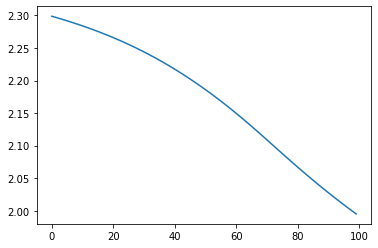



model의 output은 :  [0.07225784 0.05514308 0.18739523 0.14532685 0.05446793 0.1470713
 0.13679802 0.03832017 0.0799971  0.08322256]
argmax를 한 후의 output은 2
accuracy는 0.6648148148148149


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_8_mini

0 2.286072254180908


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.9946966171264648
20 1.8110899925231934
30 1.705086350440979
40 1.6341556310653687
50 1.5877987146377563
60 1.557530164718628
70 1.5365886688232422
80 1.5215654373168945
90 1.5107204914093018


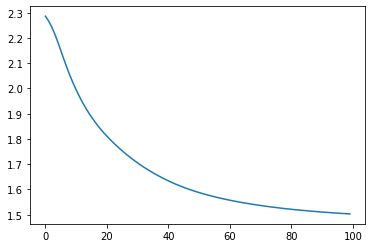



model의 output은 :  [0.00362243 0.79355764 0.0837601  0.00573782 0.00101429 0.00203635
 0.02523184 0.0097466  0.0683182  0.00697474]
argmax를 한 후의 output은 1
accuracy는 0.95


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_8_mini

0 2.072554349899292


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4979393482208252
20 1.4748836755752563
30 1.469280481338501
40 1.466847538948059
50 1.4653475284576416
60 1.4644711017608643
70 1.4639657735824585
80 1.4635056257247925
90 1.4631905555725098


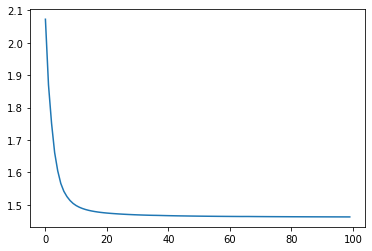



model의 output은 :  [1.0868148e-04 9.9538380e-01 5.7600508e-04 3.4113877e-04 3.1480391e-05
 9.4522448e-04 3.1372241e-04 2.3239906e-04 6.6354574e-04 1.4040822e-03]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_8_mini

0 2.0130832195281982


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.6593067646026611
20 1.6055443286895752
30 1.5744956731796265
40 1.5553241968154907
50 1.542449712753296
60 1.5336896181106567
70 1.5274121761322021
80 1.5225423574447632
90 1.518516182899475


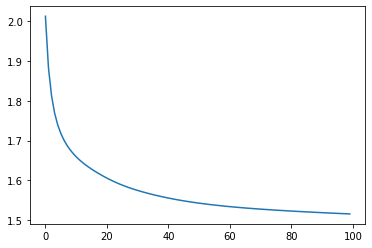



model의 output은 :  [5.3945172e-04 8.9313740e-01 1.9549211e-02 6.2054041e-04 7.1624992e-03
 2.3949990e-02 8.1001949e-03 2.8195868e-03 1.7427063e-02 2.6694078e-02]
argmax를 한 후의 output은 1
accuracy는 0.9629629629629629


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_8_mini

0 1.575609564781189


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4659641981124878
20 1.4636285305023193
30 1.4628195762634277
40 1.4624066352844238
50 1.4621597528457642
60 1.4620070457458496
70 1.4618964195251465
80 1.4617958068847656
90 1.4617211818695068


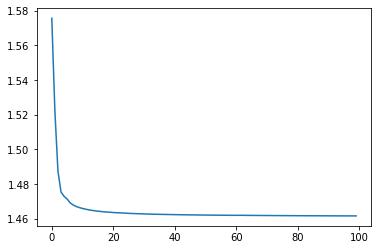



model의 output은 :  [5.8884274e-05 9.9861658e-01 4.3839196e-04 8.1042133e-05 2.6956641e-05
 2.6779802e-04 3.1284406e-04 1.3803226e-04 1.8632703e-05 4.0861647e-05]
argmax를 한 후의 output은 1
accuracy는 0.9703703703703703


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_8_mini

0 1.9627289772033691


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.5654754638671875
20 1.4791233539581299
30 1.4626911878585815
40 1.4716695547103882
50 1.461453914642334
60 1.4617794752120972
70 1.4615963697433472
80 1.4615118503570557
90 1.4614629745483398


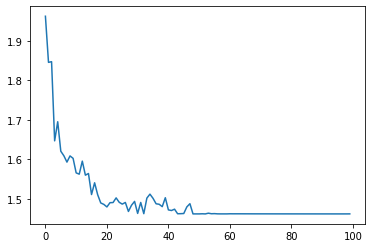



model의 output은 :  [4.5588484e-11 9.9991333e-01 6.2021754e-05 7.5137809e-06 6.2159660e-07
 5.5422279e-06 2.5628235e-06 2.6157903e-07 8.2116003e-06 2.5551310e-08]
argmax를 한 후의 output은 1
accuracy는 0.9592592592592593


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_8_mini

0 1.5436171293258667


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4639973640441895
20 1.462199330329895
30 1.4614341259002686
40 1.4612568616867065
50 1.4611905813217163
60 1.461165428161621
70 1.4611560106277466
80 1.46115243434906
90 1.4611510038375854


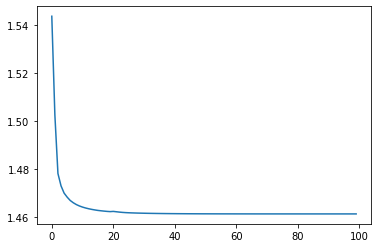



model의 output은 :  [1.8884506e-08 9.9999952e-01 7.7384277e-09 5.1981523e-08 3.8359708e-08
 1.3067716e-09 1.1182326e-07 4.4275971e-08 5.2534311e-08 1.4254373e-07]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_8_mini

0 1.8630341291427612


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.5768786668777466
20 1.5120351314544678
30 1.5340731143951416
40 1.5782225131988525
50 1.5101392269134521
60 1.4619503021240234
70 1.50118887424469
80 1.4875727891921997
90 1.5098938941955566


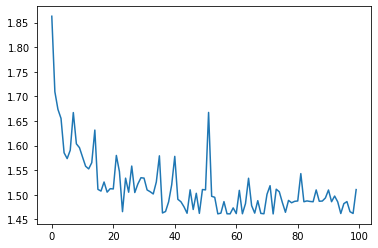



model의 output은 :  [1.59675929e-12 9.99796808e-01 1.84902615e-06 1.01496604e-04
 7.63576224e-09 3.38495121e-09 9.98389369e-05 9.64199966e-13
 1.84660465e-08 1.64690327e-11]
argmax를 한 후의 output은 1
accuracy는 0.9203703703703704


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_8_mini

0 2.387979745864868


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.387979745864868
20 2.387979745864868
30 2.387979745864868
40 2.387979745864868
50 2.387979745864868
60 2.387979745864868
70 2.387979745864868
80 2.387979745864868
90 2.387979745864868


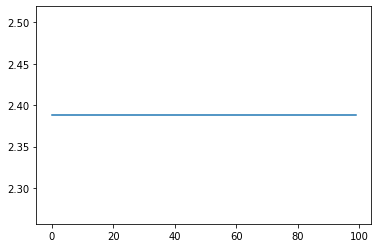



model의 output은 :  [1.7652889e-21 1.3452991e-21 3.9938907e-22 2.4770376e-21 7.5120108e-21
 2.0897794e-19 5.7478398e-17 1.3739255e-24 5.6451787e-20 1.0000000e+00]
argmax를 한 후의 output은 9
accuracy는 0.1


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_8_mini

0 1.9028897285461426


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4695976972579956
20 1.4641053676605225
30 1.4627450704574585
40 1.4622061252593994
50 1.461853265762329
60 1.461664080619812
70 1.4615434408187866
80 1.4614603519439697
90 1.4614005088806152


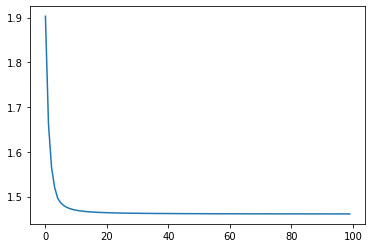



model의 output은 :  [1.0735082e-05 9.9977130e-01 2.2043601e-05 1.8647403e-05 3.2386084e-05
 2.9596615e-05 2.3984510e-05 3.7753987e-05 5.1406223e-05 2.2365925e-06]
argmax를 한 후의 output은 1
accuracy는 0.9777777777777777


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_8_mini

0 1.5468661785125732


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.462707281112671
20 1.4835299253463745
30 1.4650696516036987
40 1.5225597620010376
50 1.5143173933029175
60 1.5353264808654785
70 1.5351170301437378
80 1.5868881940841675
90 1.5642011165618896


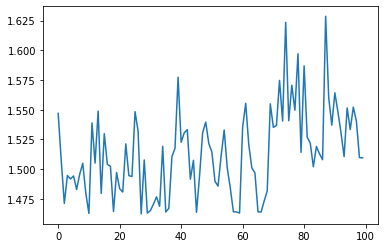



model의 output은 :  [1.7834790e-08 8.5389674e-01 9.2440359e-02 1.6799052e-03 2.7634724e-07
 5.1909413e-02 6.4373424e-05 1.4432094e-08 4.6407822e-06 4.2489296e-06]
argmax를 한 후의 output은 1
accuracy는 0.8907407407407407


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_8_mini

0 1.8710920810699463


<ipython-input-17-677bb2f269bd>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.412369966506958
20 2.412369966506958
30 2.412369966506958
40 2.412369966506958
50 2.412369966506958
60 2.412369966506958
70 2.412369966506958
80 2.412369966506958
90 2.412369966506958


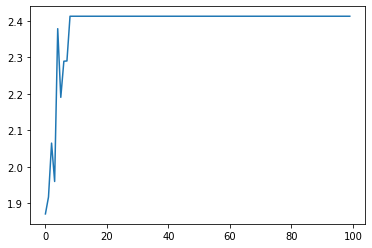



model의 output은 :  [9.7070711e-21 8.1317908e-19 4.3379444e-28 1.8872412e-16 1.0000000e+00
 1.1113011e-19 6.3435628e-19 3.4638592e-20 4.4770494e-19 4.5292507e-20]
argmax를 한 후의 output은 4
accuracy는 0.1


In [47]:
for opt in opts:
    for lr in lrs:
        model = Model()
        model.apply(init_weights_x)
        criterion = nn.CrossEntropyLoss()
        optimizer = SetOptimizer(opt, lr)
        print('\n==========================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_8_mini\n')
        losses = []
        for epoch in range(100):
            for x, y in dataloader:
                optimizer.zero_grad()
                y = y.squeeze(dim=-1)
                cost = criterion(model(x), y)
                cost.backward()
                optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_8_mini', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

4. model_9

In [48]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(64, 200, bias=True),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(200))
        self.layer2 = nn.Sequential(nn.Linear(200, 80, bias=True),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(80, 30, bias=True),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(30, 10, bias=True),
                                    nn.Softmax())

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        return output

<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




최적화 함수:  {'sgd'} 학습률:  {0.001} 모델: model_9_mini

0 2.2870371341705322
10 2.271113872528076
20 2.2526257038116455
30 2.232131242752075
40 2.2101237773895264
50 2.1871910095214844
60 2.164038896560669
70 2.1403276920318604
80 2.116447687149048
90 2.0923798084259033


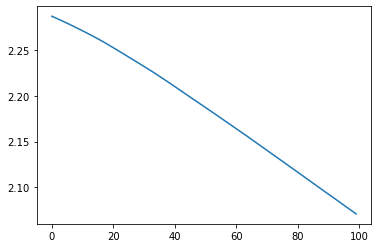



model의 output은 :  [0.01779693 0.04656386 0.23320346 0.03074388 0.08936186 0.2320668
 0.15361921 0.06227812 0.00493572 0.1294301 ]
argmax를 한 후의 output은 2
accuracy는 0.4074074074074074


최적화 함수:  {'sgd'} 학습률:  {0.01} 모델: model_9_mini

0 2.335911989212036


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.1932501792907715
20 1.9974348545074463
30 1.9429012537002563
40 1.884934902191162
50 1.8209043741226196
60 1.7805536985397339
70 1.7331695556640625
80 1.7006337642669678
90 1.6859933137893677


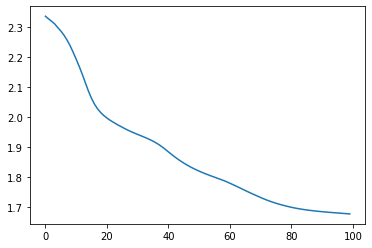



model의 output은 :  [2.53210543e-04 9.90897715e-01 9.94150410e-04 2.26290990e-03
 9.41736042e-04 2.38909943e-05 1.14059064e-03 1.20828154e-04
 1.66431000e-03 1.70068548e-03]
argmax를 한 후의 output은 1
accuracy는 0.7944444444444444


최적화 함수:  {'sgd'} 학습률:  {0.1} 모델: model_9_mini

0 2.0483484268188477


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4905648231506348
20 1.4664416313171387
30 1.4640309810638428
40 1.4631617069244385
50 1.4627537727355957
60 1.4623736143112183
70 1.462033987045288
80 1.4618756771087646
90 1.4618667364120483


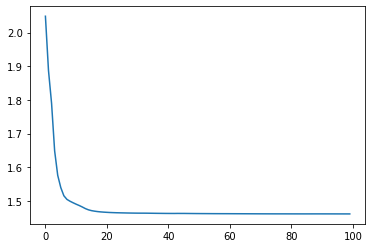



model의 output은 :  [4.5990860e-09 9.9987650e-01 7.3973006e-06 1.8969551e-05 4.1486052e-07
 9.1558398e-08 5.6195546e-05 3.4061671e-07 3.2236272e-07 3.9647817e-05]
argmax를 한 후의 output은 1
accuracy는 0.9722222222222222


최적화 함수:  {'Adagrad'} 학습률:  {0.001} 모델: model_9_mini

0 2.175060272216797


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.69826078414917
20 1.5949883460998535
30 1.547961711883545
40 1.5287760496139526
50 1.518554925918579
60 1.51199209690094
70 1.5062147378921509
80 1.4981392621994019
90 1.4866201877593994


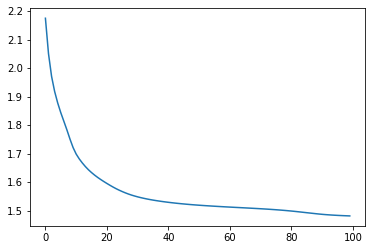



model의 output은 :  [1.2197431e-05 8.5901749e-01 8.3346017e-02 5.7542049e-03 4.8295590e-03
 6.2902068e-04 3.5276066e-03 1.5165297e-04 3.9437776e-03 3.8788471e-02]
argmax를 한 후의 output은 1
accuracy는 0.9555555555555556


최적화 함수:  {'Adagrad'} 학습률:  {0.01} 모델: model_9_mini

0 1.5462876558303833


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.463894009590149
20 1.4615871906280518
30 1.4614086151123047
40 1.461330771446228
50 1.4612873792648315
60 1.461259365081787
70 1.4612396955490112
80 1.4612256288528442
90 1.4612141847610474


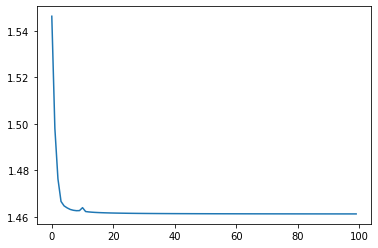



model의 output은 :  [5.6442211e-09 9.9968743e-01 1.8838310e-04 9.8042396e-10 6.2629457e-05
 2.4102368e-07 5.3805074e-05 2.7248817e-10 3.4687835e-06 4.0369509e-06]
argmax를 한 후의 output은 1
accuracy는 0.9796296296296296


최적화 함수:  {'Adagrad'} 학습률:  {0.1} 모델: model_9_mini

0 2.241335868835449


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.9959888458251953
20 1.9245651960372925
30 1.8026123046875
40 1.8026132583618164
50 1.8026010990142822
60 1.8023512363433838
70 1.8270025253295898
80 1.8022141456604004
90 1.8026137351989746


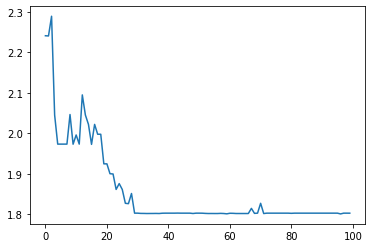



model의 output은 :  [0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 4.3578e-41 0.0000e+00 0.0000e+00 0.0000e+00]
argmax를 한 후의 output은 1
accuracy는 0.5833333333333334


최적화 함수:  {'RMSprop'} 학습률:  {0.001} 모델: model_9_mini

0 1.6707683801651


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.461629033088684
20 1.4612497091293335
30 1.461185336112976
40 1.4611610174179077
50 1.4611531496047974
60 1.4611512422561646
70 1.4611507654190063
80 1.461150884628296
90 1.4611507654190063


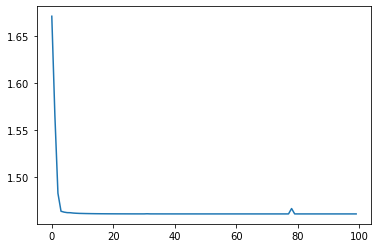



model의 output은 :  [4.6989147e-16 9.9999928e-01 1.1815247e-07 9.7670969e-12 1.4181421e-07
 4.4554147e-07 1.7467300e-09 4.0182484e-14 1.2985900e-08 1.6858664e-10]
argmax를 한 후의 output은 1
accuracy는 0.975925925925926


최적화 함수:  {'RMSprop'} 학습률:  {0.01} 모델: model_9_mini

0 2.2382588386535645


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.0216307640075684
20 1.971651554107666
30 1.8271859884262085
40 1.8995686769485474
50 1.851367473602295
60 1.656272292137146
70 1.6545741558074951
80 1.6558266878128052
90 1.729443073272705


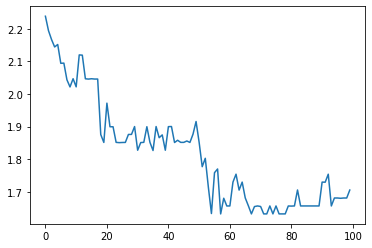



model의 output은 :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output은 1
accuracy는 0.8518518518518519


최적화 함수:  {'RMSprop'} 학습률:  {0.1} 모델: model_9_mini

0 2.290418863296509


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.290418863296509
20 2.290418863296509
30 2.290418863296509
40 2.290418863296509
50 2.290418863296509
60 2.290418863296509
70 2.290418863296509
80 2.290418863296509
90 2.290418863296509


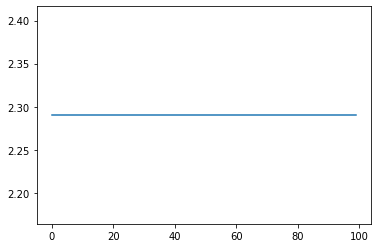



model의 output은 :  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output은 0
accuracy는 0.1


최적화 함수:  {'Adam'} 학습률:  {0.001} 모델: model_9_mini

0 1.9230488538742065


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4623277187347412
20 1.4615154266357422
30 1.4613217115402222
40 1.4612408876419067
50 1.4612072706222534
60 1.4611892700195312
70 1.4611788988113403
80 1.46117103099823
90 1.4611663818359375


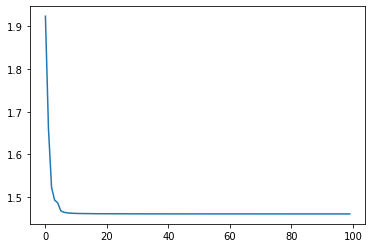



model의 output은 :  [4.2143595e-09 9.9994171e-01 3.0108549e-06 1.5003902e-06 7.5862960e-07
 4.9523828e-07 6.8176660e-06 3.1704767e-11 2.0695543e-05 2.5031892e-05]
argmax를 한 후의 output은 1
accuracy는 0.9796296296296296


최적화 함수:  {'Adam'} 학습률:  {0.01} 모델: model_9_mini

0 1.5960742235183716


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 1.4857319593429565
20 1.4612013101577759
30 1.4611510038375854
40 1.5099108219146729
50 1.5310301780700684
60 1.4855406284332275
70 1.4611504077911377
80 1.5099308490753174
90 1.4855406284332275


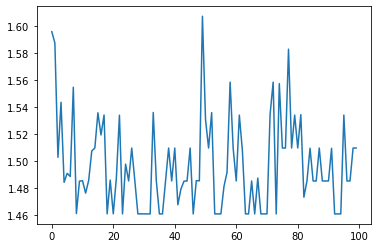



model의 output은 :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output은 1
accuracy는 0.9425925925925925


최적화 함수:  {'Adam'} 학습률:  {0.1} 모델: model_9_mini

0 2.3635895252227783


<ipython-input-18-8327ed8e6b79>:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 2.3635895252227783
20 2.3635895252227783
30 2.3635895252227783
40 2.3635895252227783
50 2.3635895252227783
60 2.3635895252227783
70 2.3635895252227783
80 2.3635895252227783
90 2.3635895252227783


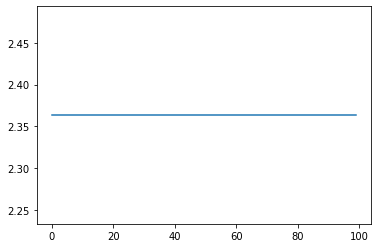



model의 output은 :  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
argmax를 한 후의 output은 8
accuracy는 0.0962962962962963


In [49]:
for opt in opts:
    for lr in lrs:
        model = Model()
        model.apply(init_weights_h)
        criterion = nn.CrossEntropyLoss()
        optimizer = SetOptimizer(opt, lr)
        print('\n==========================================================================================')
        print('\n최적화 함수: ', {opt}, '학습률: ', {lr}, '모델: model_9_mini\n')
        losses = []
        for epoch in range(100):
            for x, y in dataloader:
                optimizer.zero_grad()
                y = y.squeeze(dim=-1)
                cost = criterion(model(x), y)
                cost.backward()
                optimizer.step()
            losses.append(cost.item())
            if epoch % 10 == 0:
                print(epoch, cost.item())
        plt.plot(losses)
        plt.show()
        print('\n')
        with torch.no_grad():
            y_pred = model(x_test)
            y_pred = y_pred.detach().numpy()
            predicted = np.argmax(y_pred, axis =1)
            accuracy = (accuracy_score(predicted, y_test))
        print(f'model의 output은 :  {y_pred[0]}')
        print(f'argmax를 한 후의 output은 {predicted[0]}')
        print(f'accuracy는 {accuracy}')
        row = {'epoch': epoch, 'model': 'model_9_mini', 'optimizer': opt, 'learning_rate': lr, 'loss': cost.item(), 'accuracy': accuracy}
        result = result.append(row, ignore_index=True)

In [50]:
result.sort_values('accuracy', ascending=False).head(30)

,loss,learning_rate,optimizer,accuracy,epoch,model
114,1.461165,0.001,RMSprop,0.988889,99,model_4_mini
76,1.589448,0.010,Adagrad,0.985185,99,model_7
77,1.466393,0.100,Adagrad,0.983333,99,model_7
90,1.465377,0.001,RMSprop,0.983333,99,model_8
129,1.462903,0.001,Adam,0.981481,99,model_7_mini
134,1.462975,0.100,sgd,0.981481,99,model_8_mini
126,1.461169,0.001,RMSprop,0.981481,99,model_7_mini
82,1.464699,0.010,Adam,0.981481,99,model_7
138,1.461151,0.001,RMSprop,0.981481,99,model_8_mini
148,1.461207,0.010,Adagrad,0.979630,99,model_9_mini


## 최종 결과 분석
### 1. 최종적으로 mini-batch(64)를 적용, RMSprop optimizer 활용, 학습률이 0.001인 모델이 acc = 0.988889로 가장 높은 성능을 보였다.
### 2. batch에서와 달리 hidden layer가 2개인 모델이 가장 높은 성능을 보였다.  
### (sigmoid 함수를 활성함수로 사용하고, xavier 초기화를 사용한 점은 동일했다.)
### 3. 일반적으로 mini-batch 경사 하강을 이용한 경우, batch 경사 하강에 비해 좋은 성능을 보였다.

## 3주차 과제 2 : CNN 맛보기
- Part 1에서 수행했던 모델과 어떤 점이 달라졌는지 확인하기.
- 코드를 직접 필사하기.

- \_\_future__ : 구버전에서 상위 버전의 기능을 활용할 수 있게 하는 모듈
 - print_function: 미래에 어떤 버전을 사용하더라도 파이썬 3 문법의 print()를 사용하겠다고 선언
- argparse: 프로그램에 필요한 인자를 사용자 친화적인 명령행 인터페이스로 쉽게 작성하도록 돕는 라이브러리  
 - Script에서는 사용자가 입력한 명령행의 인자를 Parsing한 후 인자 값에 따라 적당한 동작을 수행해야 한다.
 - 딥러닝 코드를 파이썬으로 작성할 때 옵션에 따라 다양하게 실행할 수 있는데,  
 GPU가 여러 대라면 각각의 Prompt에 실행하므로, 해당 라이브러리를 활용하면 다양한 형식으로 실행시킬 수 있다.
- nn.functional: 함수로 인스턴스화 불필요 시 바로 사용 가능하다.
- nn: 클래스로 클래스의 속성을 이용해 클래스의 상태를 저장하고 활용할 수 있다.(중간값 저장 필요 시)

 

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
# Training settings
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(320, 10)
        ### : 알맞는 input은?
        ###   경고 메세지 활용
        ###   RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x320 and 128x10)
        ###   앞의 행렬의 두 번째 차원과 맞추면 된다.

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)
        x = self.fc(x)
        return F.log_softmax(x)

In [8]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [9]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        # Variable은 최근 버전에서 deprecated 상태(활용도 낮음).
        # 본래 autograd를 사용하기 위해서 사용되던 타입이었으나, 현재는 Tensor 타입과 병합되었다.
        # 즉, Tensor 타입에서 디폴트로 autograd 기능을 지원하도록 되어있다.
        # 따라서 PyTorch 0.4 이상 버전에서는 더 이상 Variable을 사용할 필요가 없으며, Tensor로 생각하면 된다.
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def test():
    model.eval()
    # model.eval() 의 기능은?
    #  eval mode에서 사용할 것이라고 모든 레이어에 선언하는 것이다.
    #  배치 정규화나 dropout layer들은 학습 모드 대신에 eval mode로 작동한다.
    #  eval 모드에서는 dropout은 비활성화되고, 배치 정규화는 학습에서 저장된 파라미터를 사용한다.
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

#### nll(Negative LogLikelyhood) loss 정리
1. nll - cross entropy 공통점
 - nll_loss와 cross entropy loss 모두 답(target)이 주어졌을 때, 현재 가지고 있는 결과값으로 정답을 추정하는 함수이다.
 - 두 함수의 역할은 정답의 확률 분포를 추정하는 것으로 동일하다.
2. nll - cross entropy 차이점
 - 정의상 CrossEntropyLoss는 LogSoftmax와 NLLLoss의 combination이다.
 - 즉, Cross Entropy는 nn.LogSoftmax와 nn.NLLLoss를 순차적으로 실행한 결과이고,  
NLL은 LogSoftmax를 자체적으로 실행하지 않는다.
 - 따라서 분류 과정 시 모델의 마지막 층에 Softmax 함수가 포함되어 있다면 NLL을, 포함되어 있지 않다면 CE를 사용한다.



In [11]:
for epoch in range(1, 10):
    train(epoch) # 직접 계산할 필요 없이, 에러 메세지를 통해 차원 알 수 있음
    test()

<ipython-input-7-f3bbf15457cb>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315223
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295723
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.283129
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.269079
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.238466
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240575
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.207284
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.144594
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.103824
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.031510
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.846891
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.754233
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.518800
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.097872
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.934014
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.794114
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.732218
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.691982
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.684664
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.484895
Train Epoch: 1 [12800/60000 (

<ipython-input-10-c28f90308027>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1636, Accuracy: 9513/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.178466
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.177327
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.257890
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.231320
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.314100
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.209090
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.204759
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.295660
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.243600
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.170956
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.061340
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.352453
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.266550
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.127029
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.178379
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.111520
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.087654
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.174188
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.114733
Train Epoch: 2 [12